In [1]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from prophet import Prophet
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')

# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)
%matplotlib inline

In [18]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')

df_daily = df_daily.rename(columns={"date": "ds", "calls": "y"})
df_daily_test = df_daily_test.rename(columns={"date": "ds", "calls": "y"})
df_hourly = df_hourly.rename(columns={"date": "ds", "calls": "y"})
df_hourly_test = df_hourly_test.rename(columns={"date": "ds", "calls": "y"})

# Sicherstellen, dass der Index von df_hourly ein DatetimeIndex ist
df_hourly.index = pd.to_datetime(df_hourly.index)

# Slice des DataFrames ab dem Index Juli 2020
df_hourly_time_modified = df_hourly[df_hourly['ds'] >= '2022-01-01']

# Sicherstellen, dass der Index von df_hourly ein DatetimeIndex ist
df_daily.index = pd.to_datetime(df_daily.index)

# Slice des DataFrames ab dem Index Juli 2020
df_daily_time_modified = df_daily[df_daily['ds'] >= '2022-01-01']

In [19]:
df_daily_time_modified.head(20)

Unnamed: 0          ds      y  days_to_holiday
1970-01-01 00:00:00.000002922        2922  2022-01-01  199.0                0
1970-01-01 00:00:00.000002923        2923  2022-01-02  171.0               -1
1970-01-01 00:00:00.000002924        2924  2022-01-03  238.0               -2
1970-01-01 00:00:00.000002925        2925  2022-01-04  251.0               -3
1970-01-01 00:00:00.000002926        2926  2022-01-05  214.0               -4
1970-01-01 00:00:00.000002927        2927  2022-01-06  247.0               -5
1970-01-01 00:00:00.000002928        2928  2022-01-07  190.0               -6
1970-01-01 00:00:00.000002929        2929  2022-01-08  199.0               -7
1970-01-01 00:00:00.000002930        2930  2022-01-09  174.0               -8
1970-01-01 00:00:00.000002931        2931  2022-01-10  222.0               -9
1970-01-01 00:00:00.000002932        2932  2022-01-11  190.0              -10
1970-01-01 00:00:00.000002933        2933  2022-01-12  173.0              -11
1970-01-01 00:00:00.000002934        2934  2022-01-13  192.0              -12
1970-01-01 00:00:00.000002935        2935  2022-01-14  187.0              -13
1970-01-01 00:00:00.000002936        2936  2022-01-15  183.0              -14
1970-01-01 00:00:00.000002937        2937  2022-01-16  160.0              -15
1970-01-01 00:00:00.000002938        2938  2022-01-17  255.0              -16
1970-01-01 00:00:00.000002939        2939  2022-01-18  207.0              -17
1970-01-01 00:00:00.000002940        2940  2022-01-19  239.0              -18
1970-01-01 00:00:00.000002941        2941  2022-01-20  192.0              -19

13:00:57 - cmdstanpy - INFO - Chain [1] start processing
13:00:59 - cmdstanpy - INFO - Chain [1] done processing
13:01:00 - cmdstanpy - INFO - Chain [1] start processing
13:01:00 - cmdstanpy - INFO - Chain [1] done processing
13:01:05 - cmdstanpy - INFO - Chain [1] start processing
13:01:22 - cmdstanpy - INFO - Chain [1] done processing
13:01:25 - cmdstanpy - INFO - Chain [1] start processing
13:01:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, 

<Figure size 1000x600 with 0 Axes>

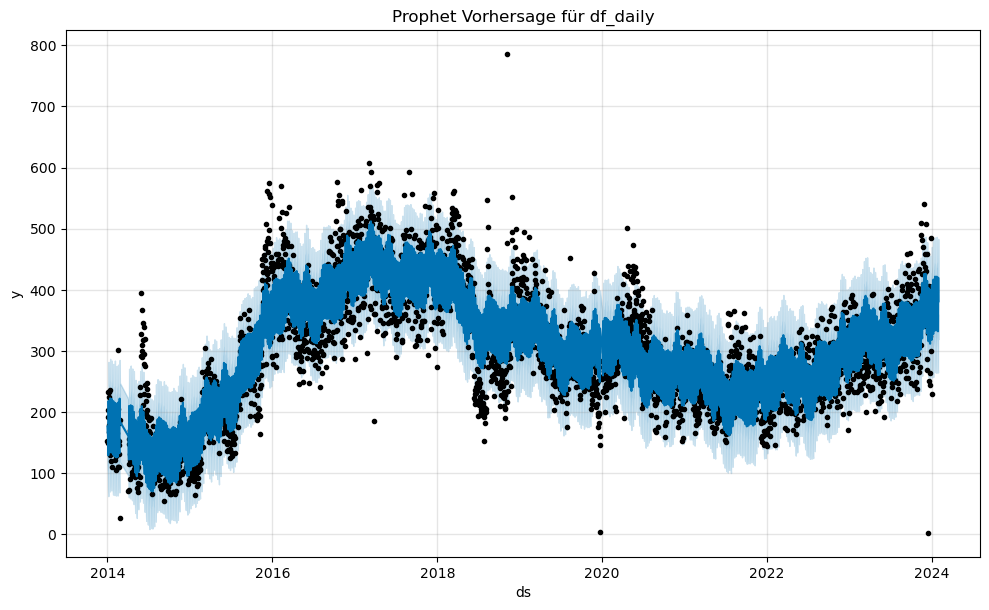

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

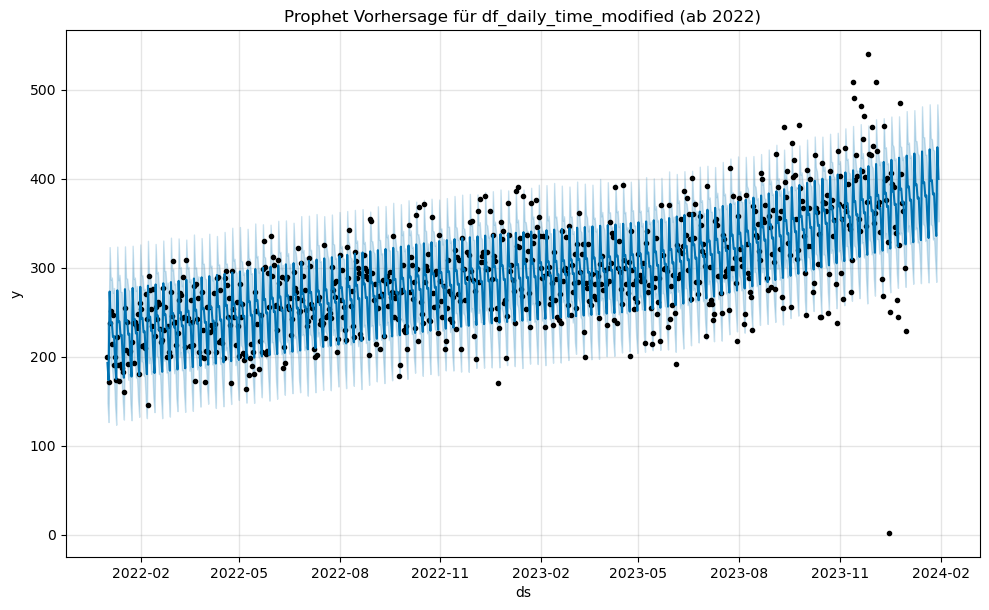

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

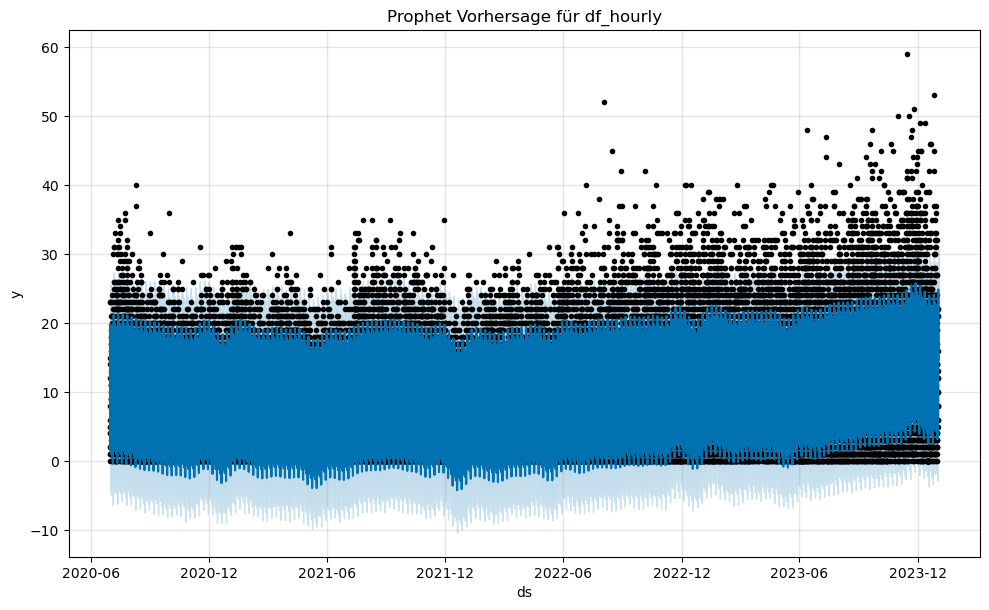

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

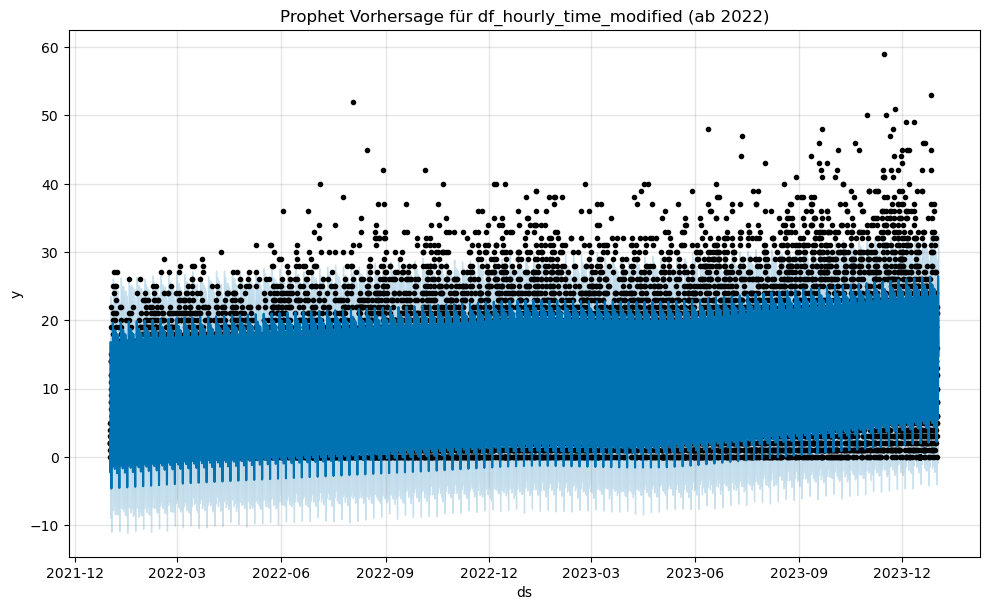

In [23]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prophet-Modell für df_daily
prophet_model_daily = Prophet()
prophet_model_daily.fit(df_daily)

# Prophet-Modell für df_daily_time_modified (ab 2022)
prophet_model_daily_time_modified = Prophet()
prophet_model_daily_time_modified.fit(df_daily_time_modified)

# Prophet-Modell für df_hourly
prophet_model_hourly = Prophet()
prophet_model_hourly.fit(df_hourly)

# Prophet-Modell für df_hourly_time_modified (ab 2022)
prophet_model_hourly_time_modified = Prophet()
prophet_model_hourly_time_modified.fit(df_hourly_time_modified)

# Vorhersage für df_daily (z.B. für die nächsten 30 Tage)
future_daily = prophet_model_daily.make_future_dataframe(periods=30)
forecast_daily = prophet_model_daily.predict(future_daily)

# Vorhersage für df_daily_time_modified (z.B. für die nächsten 30 Tage)
future_daily_time_modified = prophet_model_daily_time_modified.make_future_dataframe(periods=30)
forecast_daily_time_modified = prophet_model_daily_time_modified.predict(future_daily_time_modified)

# Vorhersage für df_hourly (z.B. für die nächsten 24 Stunden)
future_hourly = prophet_model_hourly.make_future_dataframe(periods=24, freq='H')
forecast_hourly = prophet_model_hourly.predict(future_hourly)

# Vorhersage für df_hourly_time_modified (z.B. für die nächsten 24 Stunden)
future_hourly_time_modified = prophet_model_hourly_time_modified.make_future_dataframe(periods=24, freq='H')
forecast_hourly_time_modified = prophet_model_hourly_time_modified.predict(future_hourly_time_modified)

# Plots der Vorhersagen
plt.figure(figsize=(10, 6))
prophet_model_daily.plot(forecast_daily)
plt.title('Prophet Vorhersage für df_daily')
plt.show()

plt.figure(figsize=(10, 6))
prophet_model_daily_time_modified.plot(forecast_daily_time_modified)
plt.title('Prophet Vorhersage für df_daily_time_modified (ab 2022)')
plt.show()

plt.figure(figsize=(10, 6))
prophet_model_hourly.plot(forecast_hourly)
plt.title('Prophet Vorhersage für df_hourly')
plt.show()

plt.figure(figsize=(10, 6))
prophet_model_hourly_time_modified.plot(forecast_hourly_time_modified)
plt.title('Prophet Vorhersage für df_hourly_time_modified (ab 2022)')
plt.show()


In [26]:
forecast_daily_test = prophet_model_daily.predict(df_daily_test)
forecast_daily_test_time_modified = prophet_model_daily_time_modified.predict(df_daily_test)
forecast_hourly_test = prophet_model_hourly.predict(df_hourly_test)
forecast_hourly_test_time_modified = prophet_model_hourly_time_modified.predict(df_hourly_test)
print(forecast_daily_test[["ds", "yhat", "yhat_lower", "yhat_upper"]].head())
print(forecast_hourly_test[["ds", "yhat", "yhat_lower", "yhat_upper"]].head())

          ds        yhat  yhat_lower  yhat_upper
0 2024-01-01  407.289116  347.082464  473.108764
1 2024-01-02  370.163549  305.874555  436.404844
2 2024-01-03  373.659258  309.816483  437.914641
3 2024-01-04  364.333570  301.810608  422.436986
4 2024-01-05  362.211806  294.859776  425.778378
                   ds       yhat  yhat_lower  yhat_upper
0 2024-01-01 00:00:00  10.442412    4.948211   16.716534
1 2024-01-01 01:00:00   8.649534    2.952740   14.303903
2 2024-01-01 02:00:00   7.397703    1.778019   13.108331
3 2024-01-01 03:00:00   6.458606    0.659588   12.283522
4 2024-01-01 04:00:00   5.858619   -0.124623   11.638349


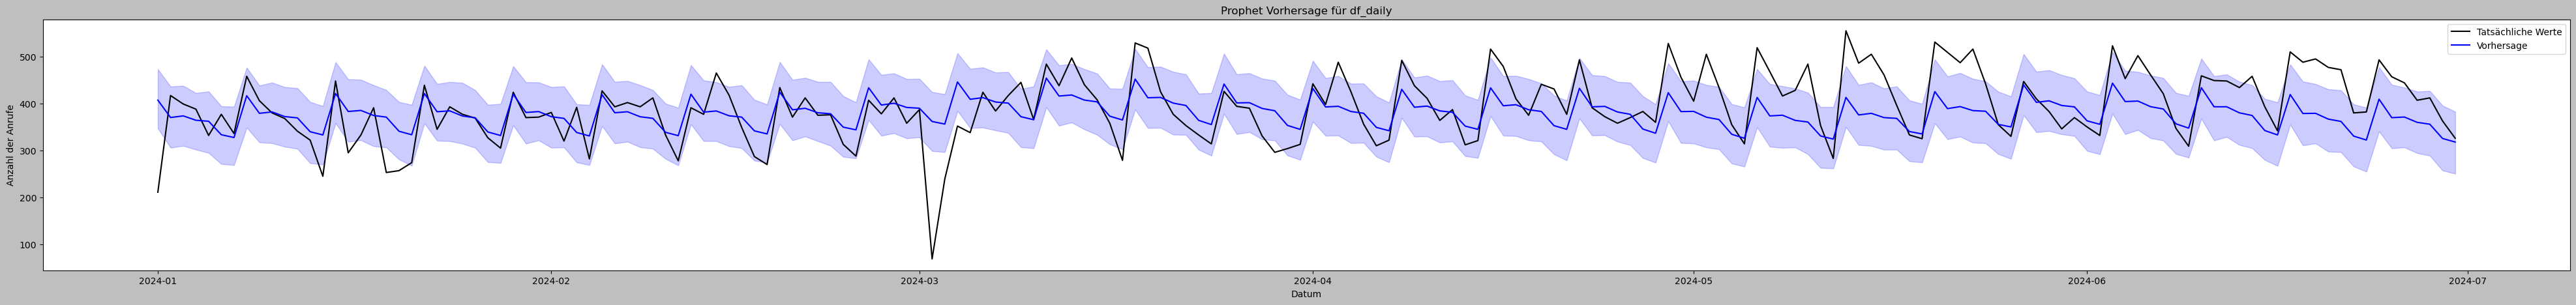

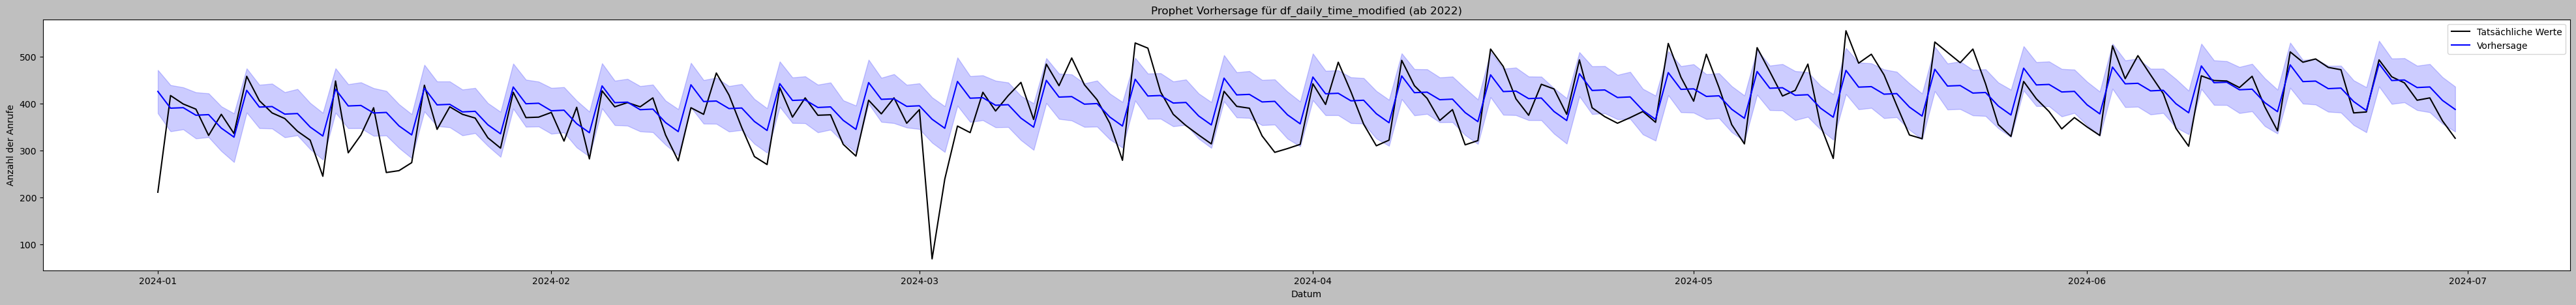

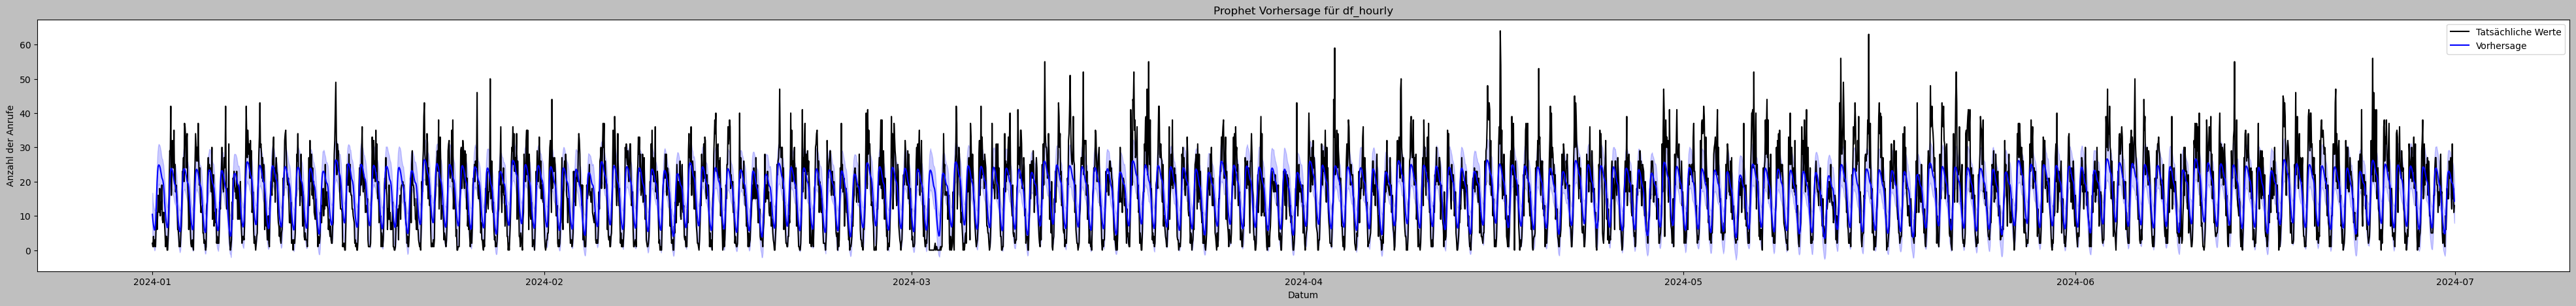

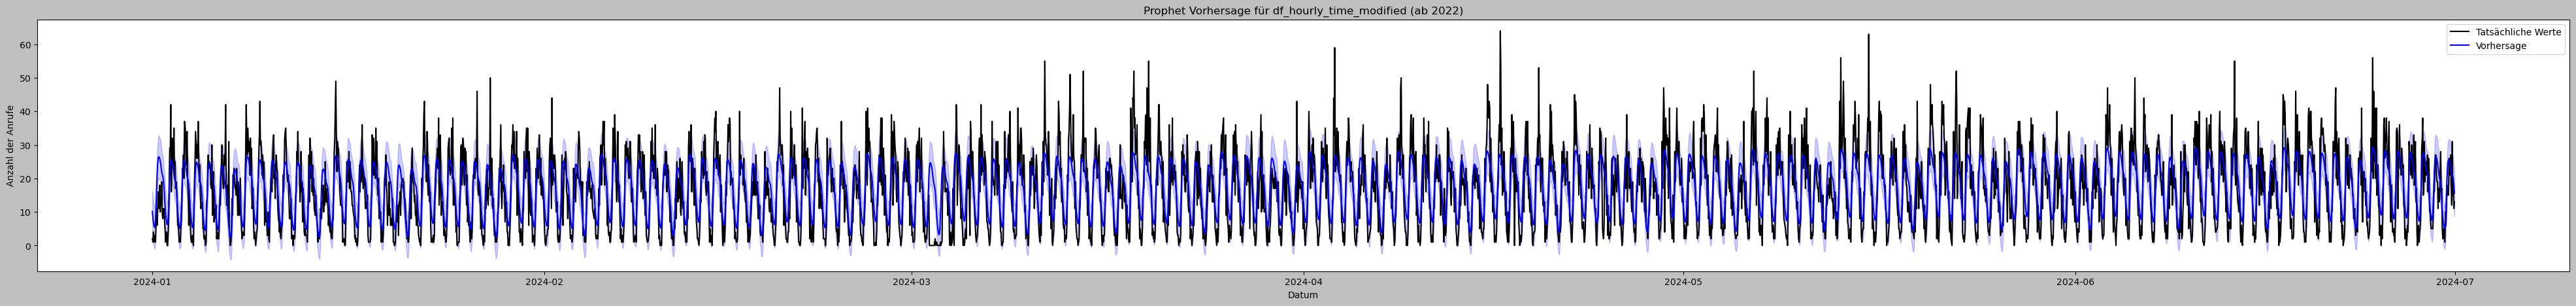

In [35]:
import matplotlib.pyplot as plt

df_daily_test["ds"] = pd.to_datetime(df_daily_test["ds"])
forecast_daily_test["ds"] = pd.to_datetime(forecast_daily_test["ds"])

df_daily_test["ds"] = pd.to_datetime(df_daily_test["ds"])
forecast_daily_test_time_modified["ds"] = pd.to_datetime(forecast_daily_test_time_modified["ds"])

df_hourly_test["ds"] = pd.to_datetime(df_hourly_test["ds"])
forecast_hourly_test["ds"] = pd.to_datetime(forecast_hourly_test["ds"])

df_hourly_test["ds"] = pd.to_datetime(df_hourly_test["ds"])
forecast_hourly_test_time_modified["ds"] = pd.to_datetime(forecast_hourly_test_time_modified["ds"])


# Funktion zur Darstellung der Vorhersage und tatsächlichen Werte
def plot_forecast(df_test, forecast, title):
    plt.figure(figsize=(50, 5))
    plt.plot(df_test["ds"], df_test["y"], label="Tatsächliche Werte", color="black")
    plt.plot(forecast["ds"], forecast["yhat"], label="Vorhersage", color="blue")
    plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="blue", alpha=0.2)
    plt.xlabel("Datum")
    plt.ylabel("Anzahl der Anrufe")
    plt.title(title)
    plt.legend()
    plt.show()

# Plots für alle vier Prophet-Modelle
plot_forecast(df_daily_test, forecast_daily_test, "Prophet Vorhersage für df_daily")
plot_forecast(df_daily_test, forecast_daily_test_time_modified, "Prophet Vorhersage für df_daily_time_modified (ab 2022)")
plot_forecast(df_hourly_test, forecast_hourly_test, "Prophet Vorhersage für df_hourly")
plot_forecast(df_hourly_test, forecast_hourly_test_time_modified, "Prophet Vorhersage für df_hourly_time_modified (ab 2022)")


In [37]:
import optuna
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Allgemeine Optimierungsfunktion für Prophet mit Optuna
def optimize_prophet(df_train, df_test, n_trials=50):
    def objective(trial):
        changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
        seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)

        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        
        model.fit(df_train)

        # Zukunftsdaten erstellen
        future = model.make_future_dataframe(periods=len(df_test))
        forecast = model.predict(future)

        # MAE berechnen (letzte Werte mit Testdaten vergleichen)
        mae = mean_absolute_error(df_test["y"], forecast["yhat"][-len(df_test):])
        return mae

    # Optuna-Studie starten
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    print(f"Beste Hyperparameter für Dataset:\n{study.best_params}")

    # Trainiere das beste Modell
    best_model = Prophet(**study.best_params)
    best_model.fit(df_train)

    return best_model, study.best_params


In [38]:
# Optuna-Optimierung für df_daily
prophet_model_daily, best_params_daily = optimize_prophet(df_daily, df_daily_test)

# Optuna-Optimierung für df_daily_time_modified
prophet_model_daily_time_modified, best_params_daily_time = optimize_prophet(df_daily_time_modified, df_daily_test)

# Optuna-Optimierung für df_hourly
prophet_model_hourly, best_params_hourly = optimize_prophet(df_hourly, df_hourly_test)

# Optuna-Optimierung für df_hourly_time_modified
prophet_model_hourly_time_modified, best_params_hourly_time = optimize_prophet(df_hourly_time_modified, df_hourly_test)


[I 2025-02-20 14:13:17,158] A new study created in memory with name: no-name-5b9828be-0de4-4e73-92e2-94a9f938d45c
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
14:13:18 - cmdstanpy - INFO - Chain [1] start processing
14:13:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-20 14:13:21,322] Trial 0 finis

Beste Hyperparameter für Dataset:
{'changepoint_prior_scale': 0.49569716542209585, 'seasonality_prior_scale': 0.09058086316541253}


14:16:36 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-20 14:16:39,758] A new study created in memory with name: no-name-474d2571-9327-4128-9a7c-3bce14a74b6c
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
14:16:39 - cmdstanpy - INFO - Chain [1] s

Beste Hyperparameter für Dataset:
{'changepoint_prior_scale': 0.01916310969072818, 'seasonality_prior_scale': 0.27685908236006557}


[I 2025-02-20 14:17:14,903] A new study created in memory with name: no-name-d4ba1286-2198-44c2-9d37-bb97ff3871ec
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-20 14:17:47,085] Trial 0 finis

Beste Hyperparameter für Dataset:
{'changepoint_prior_scale': 0.0011083381391741292, 'seasonality_prior_scale': 0.14591398458591567}


14:34:29 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-20 14:34:35,146] A new study created in memory with name: no-name-130a4d18-4f73-4635-a0fa-98c05b4027f5
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_6296\630823715.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
14:34:36 - cmdstanpy - INFO - Chain [1] s

Beste Hyperparameter für Dataset:
{'changepoint_prior_scale': 0.0011044674781591677, 'seasonality_prior_scale': 0.010684744811080666}


14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:41:57 - cmdstanpy - INFO - Chain [1] done processing


Beste Hyperparameter für Dataset:  
{'changepoint_prior_scale': 0.49569716542209585, 'seasonality_prior_scale': 0.09058086316541253}  
{'changepoint_prior_scale': 0.01916310969072818, 'seasonality_prior_scale': 0.27685908236006557}  
{'changepoint_prior_scale': 0.0011083381391741292, 'seasonality_prior_scale': 0.14591398458591567}  
{'changepoint_prior_scale': 0.0011044674781591677, 'seasonality_prior_scale': 0.010684744811080666}  


17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing


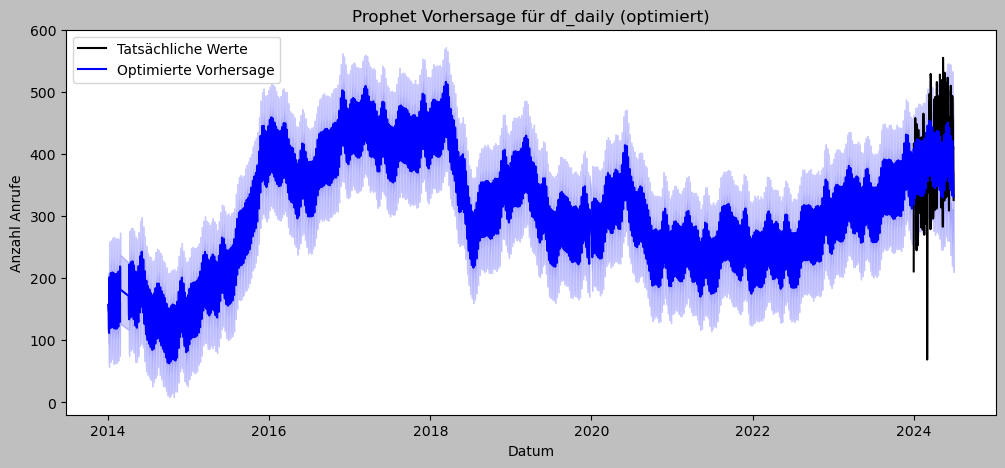

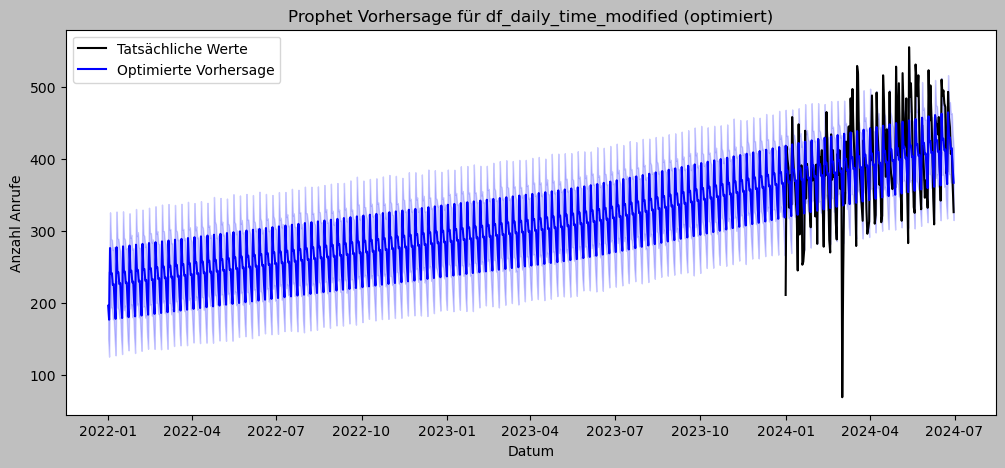

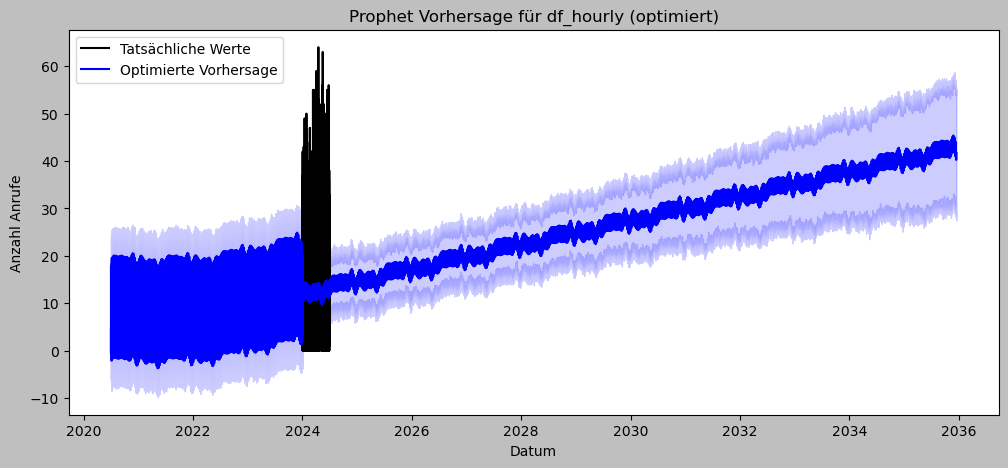

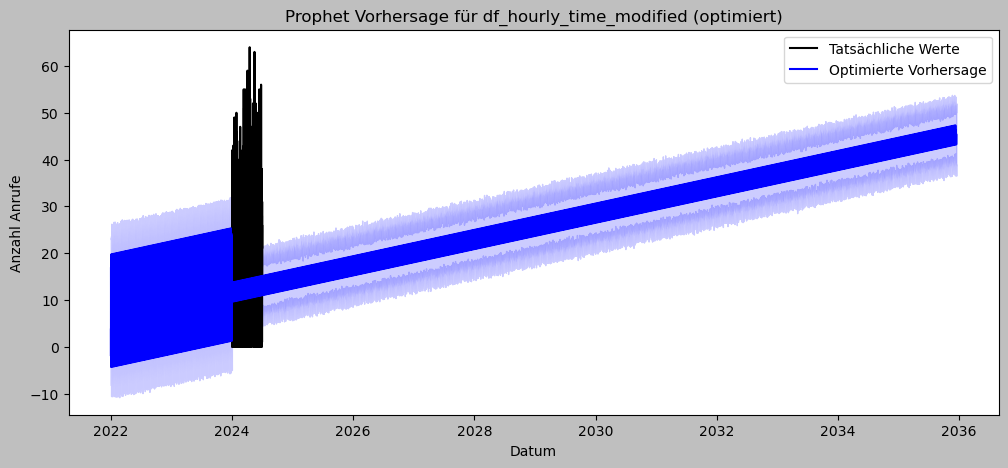

In [39]:
# Funktion zur Modellerstellung und Vorhersage
def train_and_forecast(df_train, df_test, best_params):
    model = Prophet(
        changepoint_prior_scale=best_params["changepoint_prior_scale"],
        seasonality_prior_scale=best_params["seasonality_prior_scale"]
    )
    model.fit(df_train)
    
    # Zukunftsdaten erstellen basierend auf Testdaten
    future = model.make_future_dataframe(periods=len(df_test), freq='D')
    forecast = model.predict(future)
    return model, forecast

# Optimierte Modelle für alle Datensätze
prophet_model_daily_opt, forecast_daily_opt = train_and_forecast(df_daily, df_daily_test, {
    "changepoint_prior_scale": 0.49569716542209585,
    "seasonality_prior_scale": 0.09058086316541253
})

prophet_model_daily_time_modified_opt, forecast_daily_time_modified_opt = train_and_forecast(df_daily_time_modified, df_daily_test, {
    "changepoint_prior_scale": 0.01916310969072818,
    "seasonality_prior_scale": 0.27685908236006557
})

prophet_model_hourly_opt, forecast_hourly_opt = train_and_forecast(df_hourly, df_hourly_test, {
    "changepoint_prior_scale": 0.0011083381391741292,
    "seasonality_prior_scale": 0.14591398458591567
})

prophet_model_hourly_time_modified_opt, forecast_hourly_time_modified_opt = train_and_forecast(df_hourly_time_modified, df_hourly_test, {
    "changepoint_prior_scale": 0.0011044674781591677,
    "seasonality_prior_scale": 0.010684744811080666
})

# Funktion zur Visualisierung
def plot_forecast(df_test, forecast, title):
    plt.figure(figsize=(12, 5))
    plt.plot(df_test["ds"], df_test["y"], label="Tatsächliche Werte", color="black")
    plt.plot(forecast["ds"], forecast["yhat"], label="Optimierte Vorhersage", color="blue")
    plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="blue", alpha=0.2)
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Anrufe")
    plt.title(title)
    plt.legend()
    plt.show()

# Plots für alle optimierten Modelle
plot_forecast(df_daily_test, forecast_daily_opt, "Prophet Vorhersage für df_daily (optimiert)")
plot_forecast(df_daily_test, forecast_daily_time_modified_opt, "Prophet Vorhersage für df_daily_time_modified (optimiert)")
plot_forecast(df_hourly_test, forecast_hourly_opt, "Prophet Vorhersage für df_hourly (optimiert)")
plot_forecast(df_hourly_test, forecast_hourly_time_modified_opt, "Prophet Vorhersage für df_hourly_time_modified (optimiert)")


In [41]:
def evaluate_model(true_values, predictions, model_name):
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(true_values, predictions)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    
    # MSE (Mean Squared Error)
    mse = mean_squared_error(true_values, predictions)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    
    # Ergebnisse ausgeben
    print(f"{model_name} Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}\n")

# Evaluation für alle vier Prophet-Modelle
evaluate_model(df_daily_test['y'], forecast_daily_test['yhat'], "Prophet df_daily")
evaluate_model(df_daily_test['y'], forecast_daily_test_time_modified['yhat'], "Prophet df_daily_time_modified")
evaluate_model(df_hourly_test['y'], forecast_hourly_test['yhat'], "Prophet df_hourly")
evaluate_model(df_hourly_test['y'], forecast_hourly_test_time_modified['yhat'], "Prophet df_hourly_time_modified")


Prophet df_daily Evaluation:
MAE: 46.3353
MAPE: 13.8240%
MSE: 3820.9789
RMSE: 61.8141

Prophet df_daily_time_modified Evaluation:
MAE: 40.7412
MAPE: 13.2615%
MSE: 2869.3999
RMSE: 53.5668

Prophet df_hourly Evaluation:
MAE: 5.4030
MAPE: inf%
MSE: 49.2168
RMSE: 7.0155

Prophet df_hourly_time_modified Evaluation:
MAE: 5.2685
MAPE: inf%
MSE: 45.4030
RMSE: 6.7382



In [38]:
df_daily['ds'] = pd.to_datetime(df_daily['ds'])
df_daily_test['ds'] = pd.to_datetime(df_daily_test['ds'])
df_hourly['ds'] = pd.to_datetime(df_hourly['ds'])
df_hourly_test['ds'] = pd.to_datetime(df_hourly_test['ds'])

In [39]:
prophet_model_daily = Prophet()
prophet_model_daily.fit(df_daily)
prophet_model_hourly = Prophet()
prophet_model_hourly.fit(df_hourly)

09:36:37 - cmdstanpy - INFO - Chain [1] start processing
09:36:39 - cmdstanpy - INFO - Chain [1] done processing
09:36:43 - cmdstanpy - INFO - Chain [1] start processing
09:36:57 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future_daily = df_daily_test[['ds']]  # Nur die Zeitstempel der Testdaten
forecast_daily = prophet_model_daily.predict(future_daily)

future_hourly = df_hourly_test[['ds']]  # Nur die Zeitstempel der Testdaten
forecast_hourly = prophet_model_hourly.predict(future_hourly)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Daily
y_true_daily = df_daily_test['y']
y_pred_daily = forecast_daily.set_index('ds').loc[df_daily_test['ds'], 'yhat']
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
mse_daily = mean_squared_error(y_true_daily, y_pred_daily)

print(f"Daily - MAE: {mae_daily}, MSE: {mse_daily}")

# Hourly
y_true_hourly = df_hourly_test['y']
y_pred_hourly = forecast_hourly.set_index('ds').loc[df_hourly_test['ds'], 'yhat']
mae_hourly = mean_absolute_error(y_true_hourly, y_pred_hourly)
mse_hourly = mean_squared_error(y_true_hourly, y_pred_hourly)

print(f"Hourly - MAE: {mae_hourly}, MSE: {mse_hourly}")

Daily - MAE: 46.33531377308879, MSE: 3820.97885830202
Hourly - MAE: 5.403004642334944, MSE: 49.216824323593


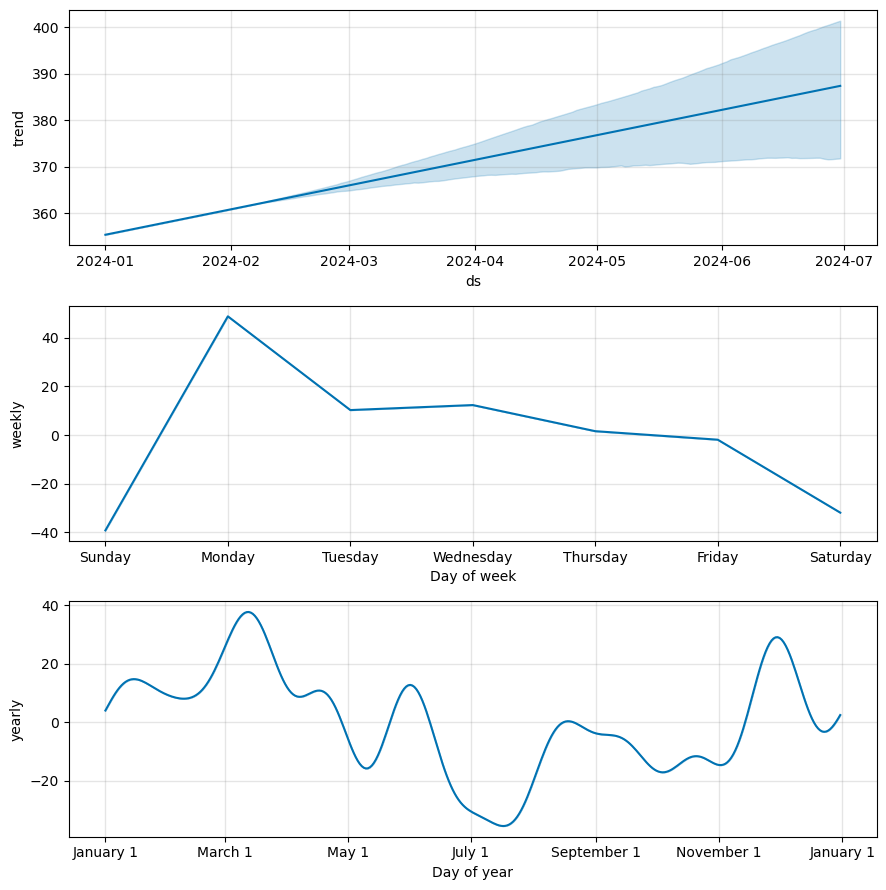

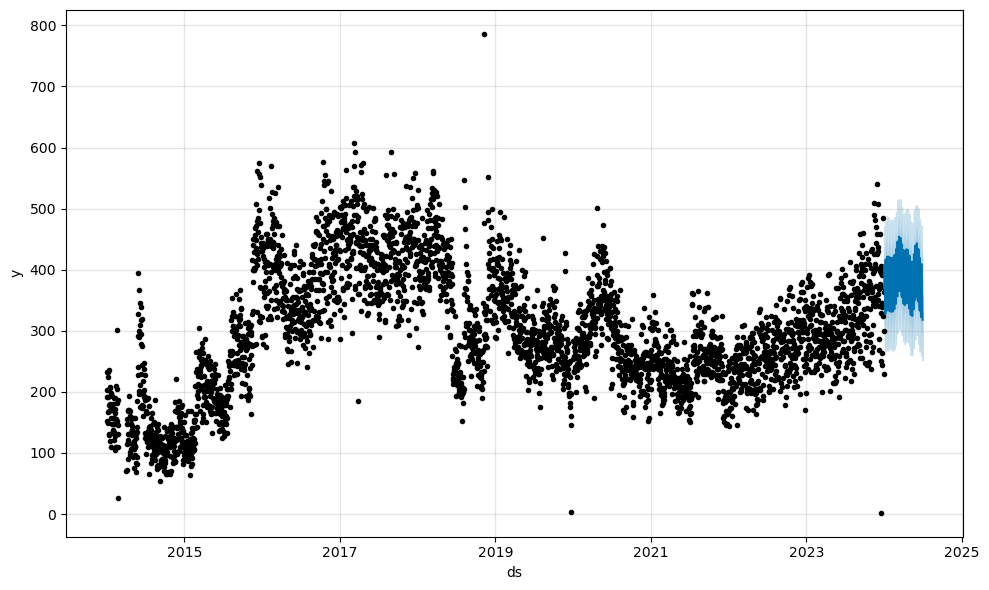

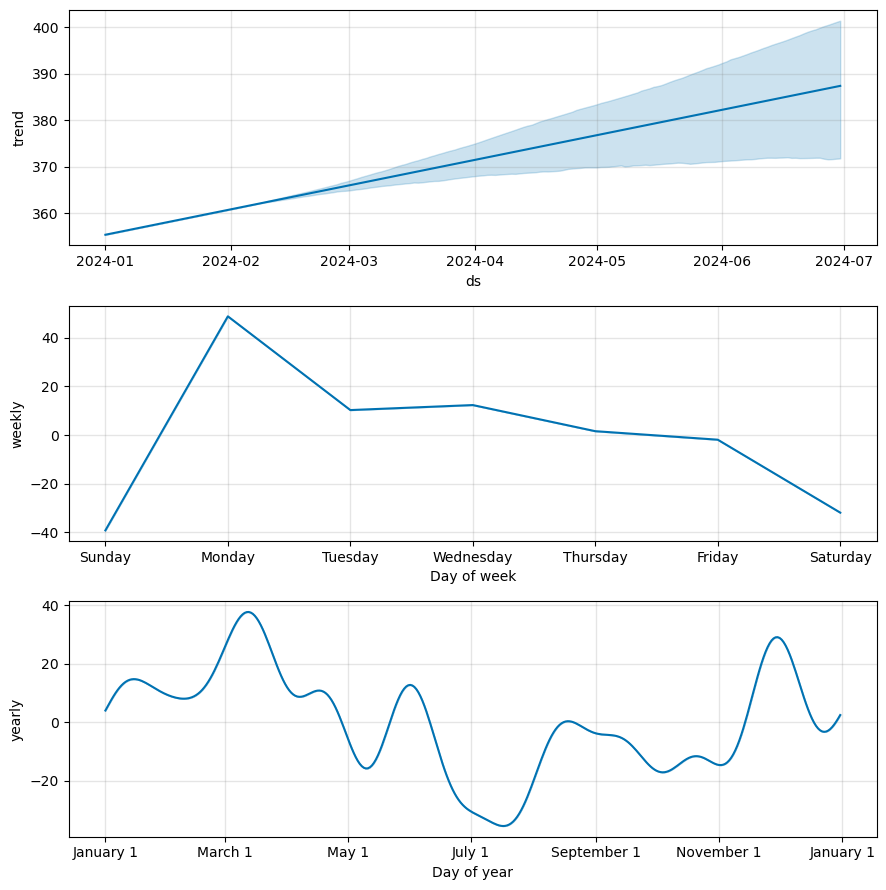

In [42]:
prophet_model_daily.plot(forecast_daily)
prophet_model_daily.plot_components(forecast_daily)

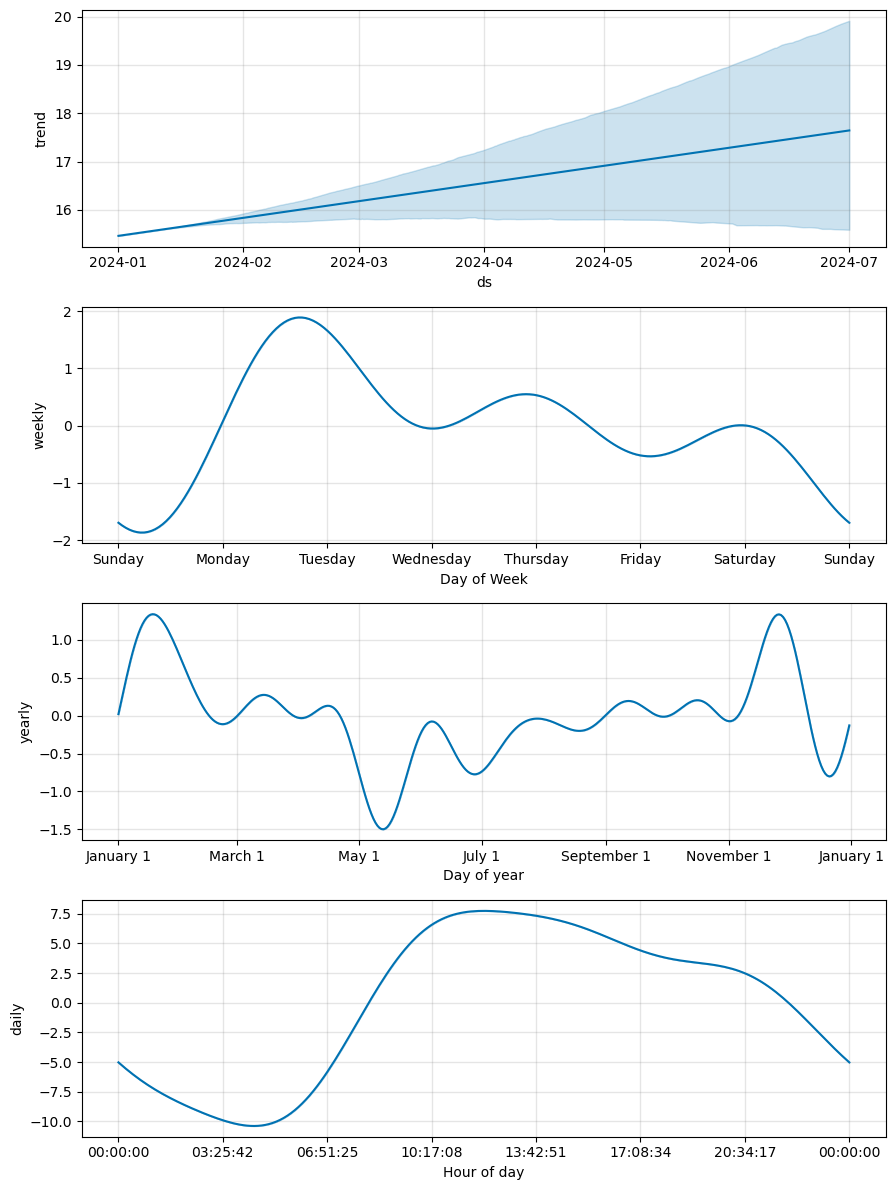

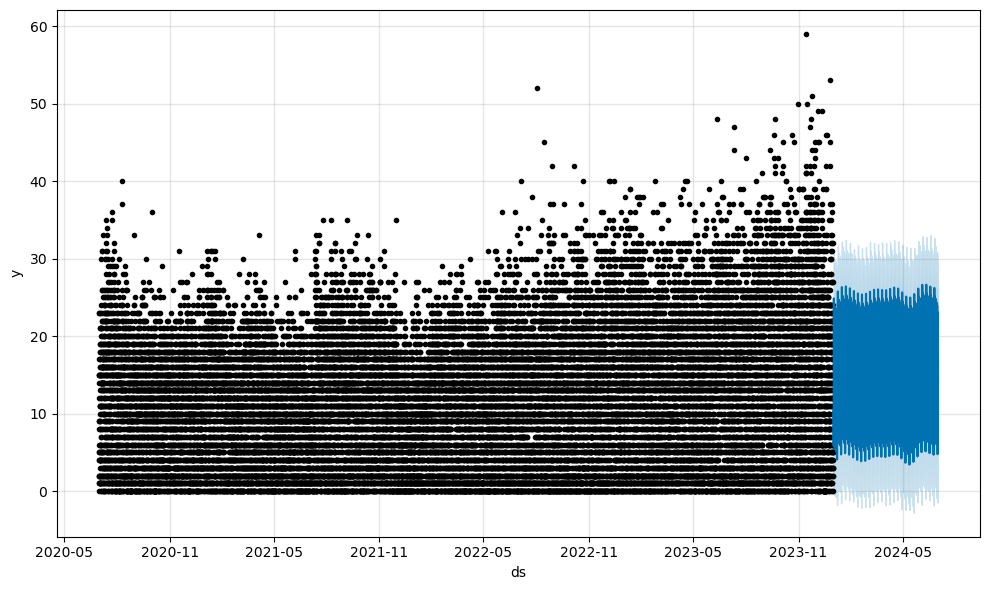

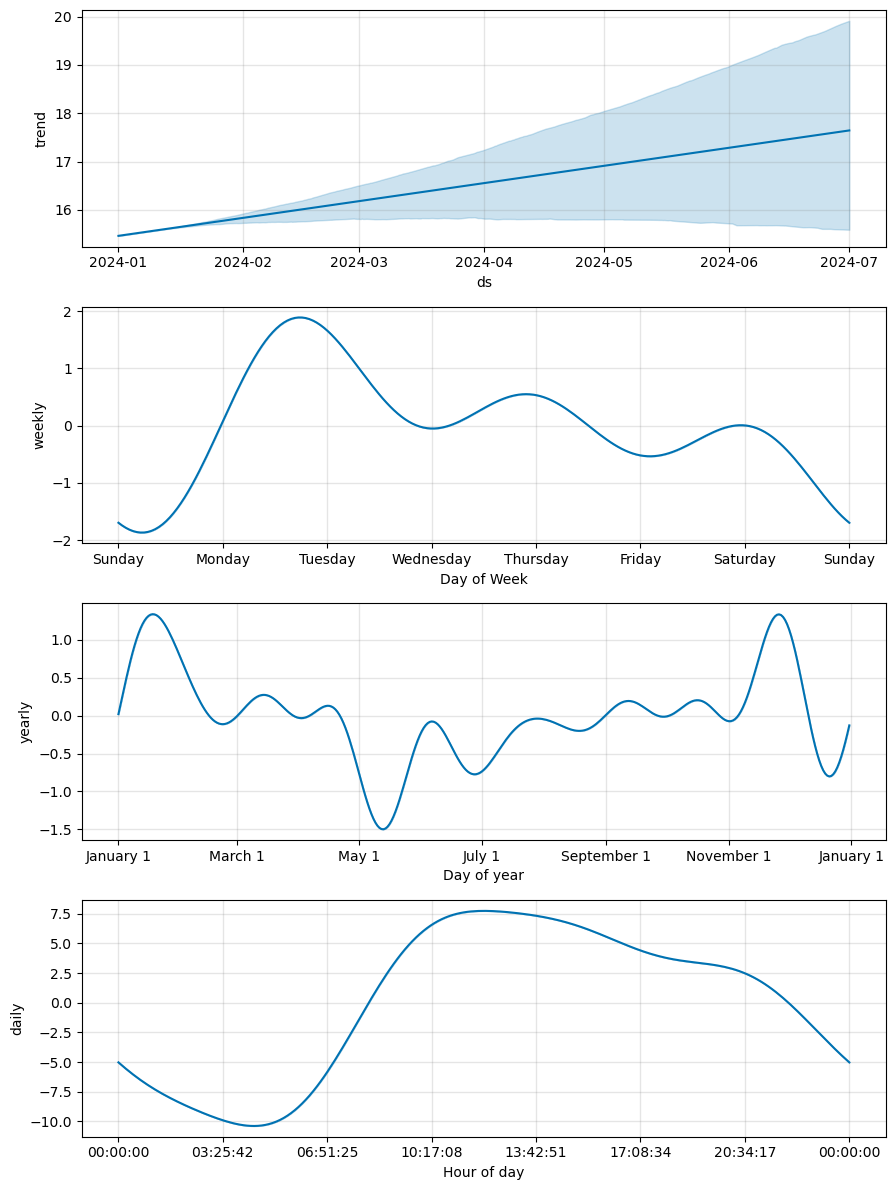

In [43]:
prophet_model_hourly.plot(forecast_hourly)
prophet_model_hourly.plot_components(forecast_hourly)

        Unnamed: 0                   ds            y  days_to_holiday
count  3652.000000                 3652  3607.000000      3652.000000
mean   1825.500000  2018-12-31 12:00:00   296.481009        -0.168949
min       0.000000  2014-01-01 00:00:00     2.000000       -64.000000
25%     912.750000  2016-07-01 18:00:00   229.500000       -15.000000
50%    1825.500000  2018-12-31 12:00:00   288.000000         0.000000
75%    2738.250000  2021-07-01 06:00:00   367.000000        15.000000
max    3651.000000  2023-12-31 00:00:00   786.000000        64.000000
std    1054.385919                  NaN   101.740170        27.069530
         Unnamed: 0                   ds             y  days_to_holiday
count  30696.000000                30696  30696.000000     30696.000000
mean   15347.500000  2022-04-01 11:30:00     11.221886         1.270524
min        0.000000  2020-07-01 00:00:00      0.000000       -64.000000
25%     7673.750000  2021-05-16 17:45:00      4.000000       -13.000000
50%    153

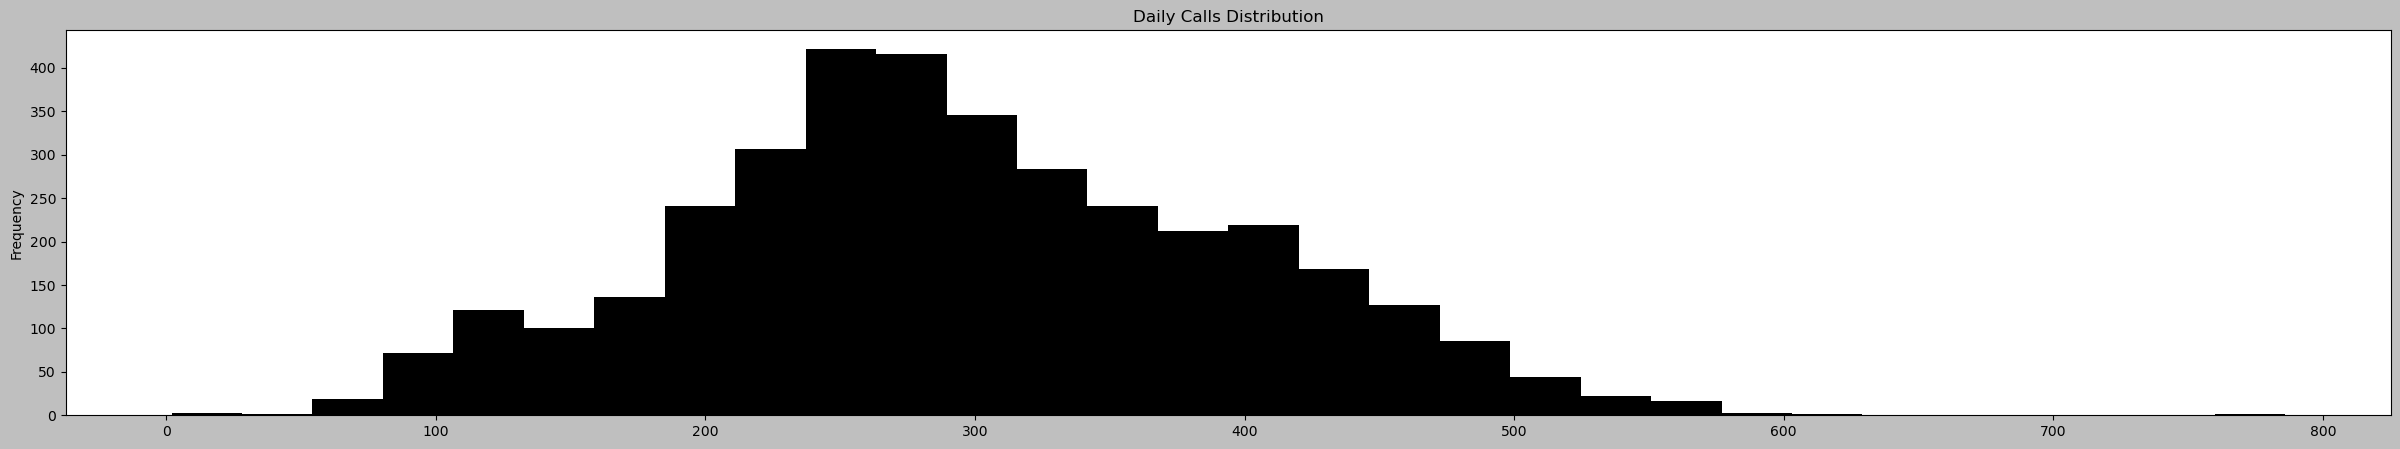

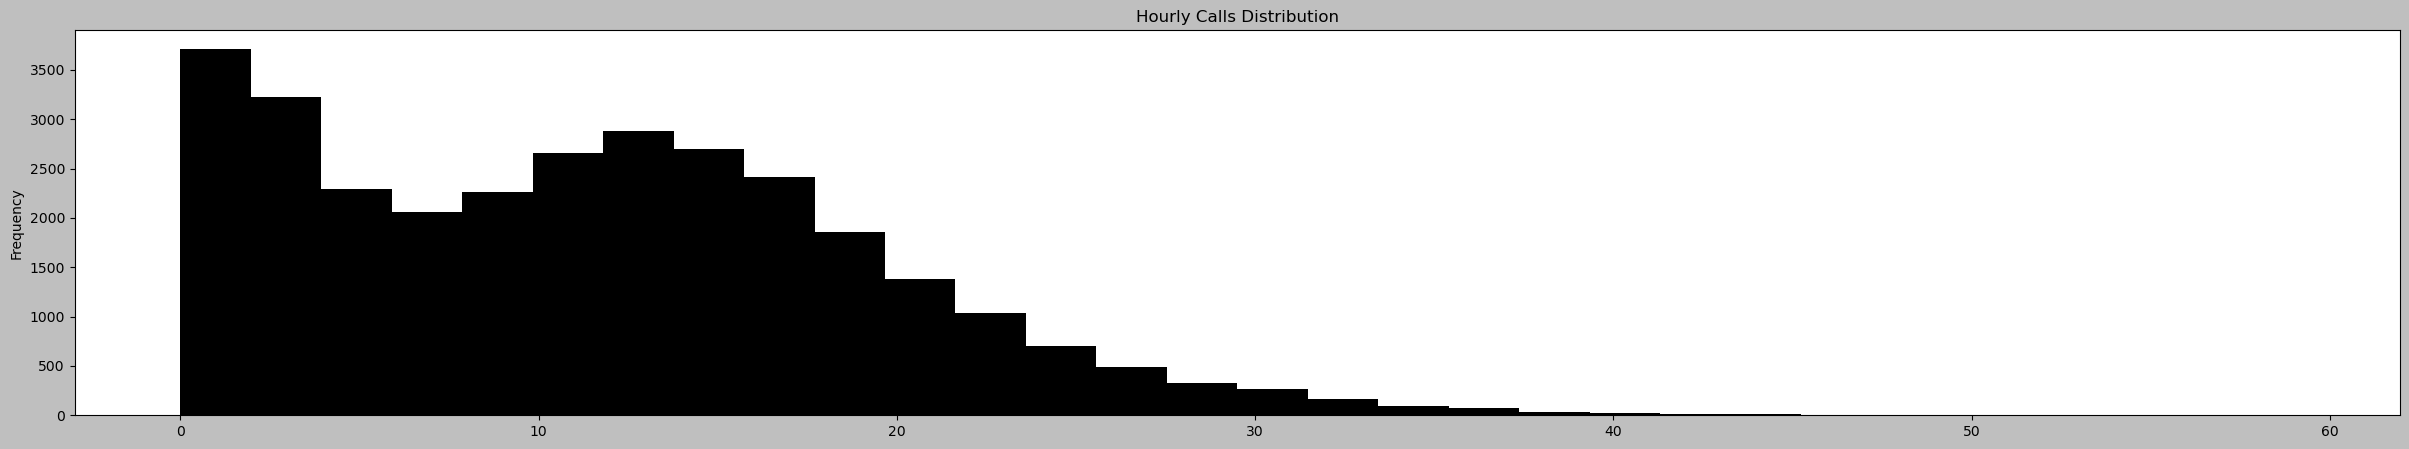

In [44]:
# Schnelle Analyse der Trainingsdaten
print(df_daily.describe())
print(df_hourly.describe())

# Überprüfung auf fehlende Werte
print(df_daily.isna().sum())
print(df_hourly.isna().sum())

# Verteilung der Anrufe visualisieren
import matplotlib.pyplot as plt
df_daily['y'].plot(title='Daily Calls Distribution', kind='hist', bins=30)
plt.show()

df_hourly['y'].plot(title='Hourly Calls Distribution', kind='hist', bins=30)
plt.show()

In [45]:
# Die 45 fehlenden Werte in y müssen behandelt werden, da Prophet keine Lücken in den Trainingsdaten toleriert.
df_daily['y'] = df_daily['y'].interpolate(method='linear')

In [46]:
# Daily Model mit Regressor
prophet_model_daily = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_model_daily.add_regressor('days_to_holiday')

# Hourly Model mit Regressor
prophet_model_hourly = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
prophet_model_hourly.add_regressor('days_to_holiday')

# Training
prophet_model_daily.fit(df_daily)
prophet_model_hourly.fit(df_hourly)

09:37:04 - cmdstanpy - INFO - Chain [1] start processing
09:37:05 - cmdstanpy - INFO - Chain [1] done processing
09:37:10 - cmdstanpy - INFO - Chain [1] start processing
09:37:29 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Daily Vorhersage
future_daily = df_daily_test[['ds', 'days_to_holiday']]  # Testdaten mit Regressoren
forecast_daily = prophet_model_daily.predict(future_daily)

# Hourly Vorhersage
future_hourly = df_hourly_test[['ds', 'days_to_holiday']]  # Testdaten mit Regressoren
forecast_hourly = prophet_model_hourly.predict(future_hourly)

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Daily
y_true_daily = df_daily_test['y']
y_pred_daily = forecast_daily.set_index('ds').loc[df_daily_test['ds'], 'yhat']
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
mse_daily = mean_squared_error(y_true_daily, y_pred_daily)

print(f"Daily - MAE: {mae_daily}, MSE: {mse_daily}")

# Hourly
y_true_hourly = df_hourly_test['y']
y_pred_hourly = forecast_hourly.set_index('ds').loc[df_hourly_test['ds'], 'yhat']
mae_hourly = mean_absolute_error(y_true_hourly, y_pred_hourly)
mse_hourly = mean_squared_error(y_true_hourly, y_pred_hourly)

print(f"Hourly - MAE: {mae_hourly}, MSE: {mse_hourly}")

Daily - MAE: 46.166048841757224, MSE: 3768.9541227574946
Hourly - MAE: 5.410685781831732, MSE: 49.207755440844416


Daily:

    Ein MAE von 46 ist hoch, besonders wenn du die Skalierung der Daten berücksichtigst (Tagesdurchschnitt bei etwa 296 Anrufen laut deinen Statistikangaben).
    Der MSE zeigt, dass einige Vorhersagen deutlich danebenliegen (Ausreißer).

Hourly:

    Ein MAE von 5.41 bei stündlichen Daten ist besser, da der Wert nahe am Median der stündlichen Anrufe (11) liegt.
    Der MSE deutet ebenfalls auf Ausreißer hin, aber sie scheinen weniger drastisch zu sein als bei den täglichen Daten.


In [49]:
y_pred_daily = y_pred_daily.set_axis(y_true_daily.index)
y_pred_hourly = y_pred_hourly.set_axis(y_true_hourly.index)


In [50]:
# Residuen berechnen
residuals_daily = y_true_daily - y_pred_daily
residuals_hourly = y_true_hourly - y_pred_hourly

# Überprüfen, ob die Berechnung funktioniert hat
print("Daily Residuals:")
print(residuals_daily.describe())

print("Hourly Residuals:")
print(residuals_hourly.describe())

Daily Residuals:
count    182.000000
mean      14.223102
std       59.886249
min     -285.607595
25%      -22.520853
50%       11.384617
75%       53.565122
max      140.994921
dtype: float64
Hourly Residuals:
count    4368.000000
mean       -0.206042
std         7.012600
min       -23.412380
25%        -4.986802
50%        -1.657001
75%         3.449964
max        41.253152
dtype: float64


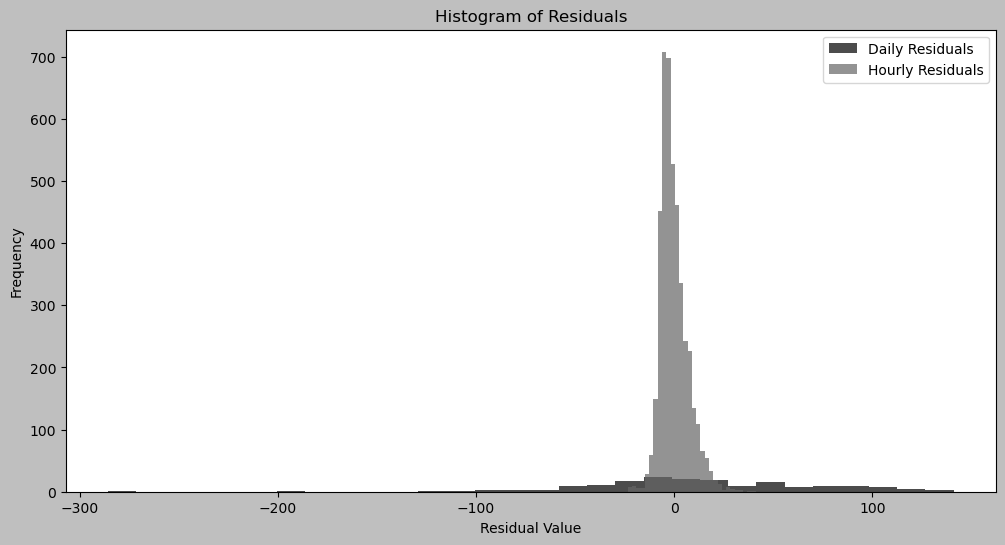

In [51]:
# Histogramme erstellen
plt.figure(figsize=(12, 6))
plt.hist(residuals_daily, bins=30, alpha=0.7, label='Daily Residuals')
plt.hist(residuals_hourly, bins=30, alpha=0.7, label='Hourly Residuals')
plt.legend()
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [52]:
print("Daily Residuals - Ausreißer:")
print(residuals_daily[residuals_daily.abs() > 3 * residuals_daily.std()])

print("Hourly Residuals - Ausreißer:")
print(residuals_hourly[residuals_hourly.abs() > 3 * residuals_hourly.std()])

Daily Residuals - Ausreißer:
0    -191.106532
61   -285.607595
dtype: float64
Hourly Residuals - Ausreißer:
139     23.756057
145     23.532883
348     22.629565
616     23.651708
641     29.714657
1190    22.085108
1233    21.742510
1474   -21.864258
1475   -23.175340
1476   -23.412380
1477   -23.159065
1478   -22.687208
1479   -21.940468
1693    29.030548
1741    26.389518
1766    28.221256
1856    23.986604
1862    26.303506
1887    23.467607
1890    34.431691
2241    24.058117
2243    34.693508
2368    22.772484
2369    26.800569
2533    21.774791
2557    39.055200
2558    29.515893
2584   -22.954123
2630    29.127520
2867    21.696480
2869   -21.608085
2878    22.960845
3038    27.256296
3063    21.465092
3138    21.701630
3201    22.847617
3203    31.369649
3208    25.919296
3237    21.402567
3256    41.253152
3373    22.599985
3422    28.128244
3761    27.648579
3950    30.743494
4066    22.261472
4142    23.118508
4212    29.705895
dtype: float64


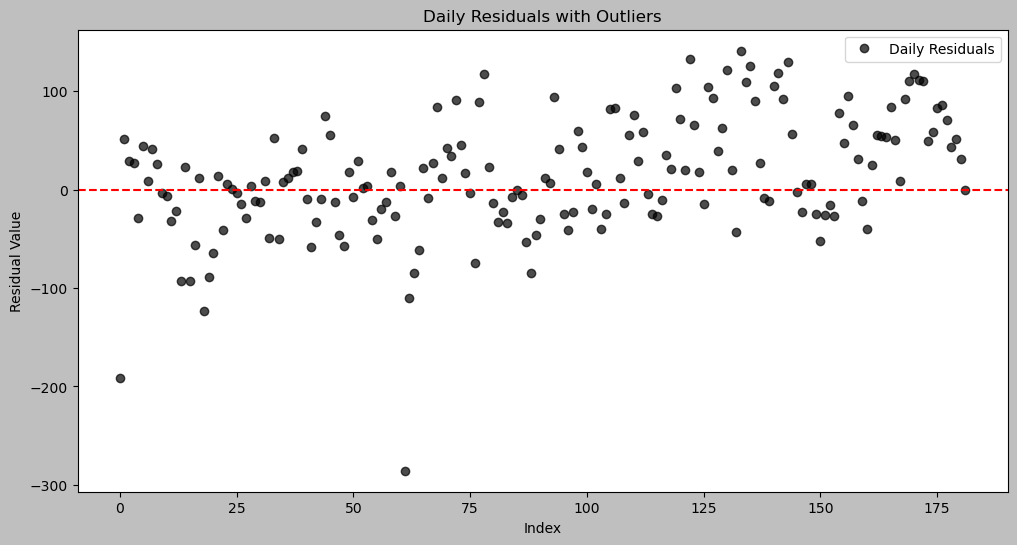

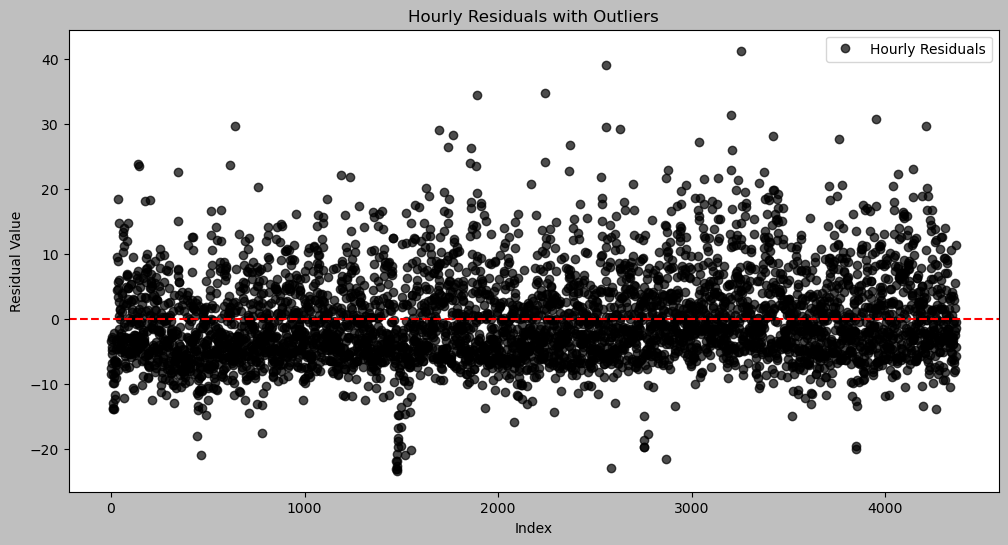

In [53]:
# Daily Residuals visualisieren
plt.figure(figsize=(12, 6))
plt.plot(residuals_daily, label='Daily Residuals', marker='o', linestyle='', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Residuals with Outliers')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

# Hourly Residuals visualisieren
plt.figure(figsize=(12, 6))
plt.plot(residuals_hourly, label='Hourly Residuals', marker='o', linestyle='', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Hourly Residuals with Outliers')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

In [54]:
daily_outliers = residuals_daily[residuals_daily.abs() > 3 * residuals_daily.std()]
hourly_outliers = residuals_hourly[residuals_hourly.abs() > 3 * residuals_hourly.std()]

print("Daily Outlier Dates:")
print(df_daily_test.loc[daily_outliers.index, 'ds'])

print("Hourly Outlier Dates:")
print(df_hourly_test.loc[hourly_outliers.index, 'ds'])

Daily Outlier Dates:
0    2024-01-01
61   2024-03-02
Name: ds, dtype: datetime64[ns]
Hourly Outlier Dates:
139    2024-01-06 19:00:00
145    2024-01-07 01:00:00
348    2024-01-15 12:00:00
616    2024-01-26 16:00:00
641    2024-01-27 17:00:00
1190   2024-02-19 14:00:00
1233   2024-02-21 09:00:00
1474   2024-03-02 10:00:00
1475   2024-03-02 11:00:00
1476   2024-03-02 12:00:00
1477   2024-03-02 13:00:00
1478   2024-03-02 14:00:00
1479   2024-03-02 15:00:00
1693   2024-03-11 13:00:00
1741   2024-03-13 13:00:00
1766   2024-03-14 14:00:00
1856   2024-03-18 08:00:00
1862   2024-03-18 14:00:00
1887   2024-03-19 15:00:00
1890   2024-03-19 18:00:00
2241   2024-04-03 09:00:00
2243   2024-04-03 11:00:00
2368   2024-04-08 16:00:00
2369   2024-04-08 17:00:00
2533   2024-04-15 13:00:00
2557   2024-04-16 13:00:00
2558   2024-04-16 14:00:00
2584   2024-04-17 16:00:00
2630   2024-04-19 14:00:00
2867   2024-04-29 11:00:00
2869   2024-04-29 13:00:00
2878   2024-04-29 22:00:00
3038   2024-05-06 14:00:00
30

In [55]:
print(df_daily_test.loc[daily_outliers.index])
print(df_hourly_test.loc[hourly_outliers.index])

    Unnamed: 0         ds    y  days_to_holiday
0            0 2024-01-01  211                0
61          61 2024-03-02   69               27
      Unnamed: 0  index                  ds   y  days_to_holiday
139          139    139 2024-01-06 19:00:00  42               -5
145          145    145 2024-01-07 01:00:00  31               -6
348          348    348 2024-01-15 12:00:00  49              -14
616          616    616 2024-01-26 16:00:00  46              -25
641          641    641 2024-01-27 17:00:00  50              -26
1190        1190   1190 2024-02-19 14:00:00  47               39
1233        1233   1233 2024-02-21 09:00:00  41               37
1474        1474   1474 2024-03-02 10:00:00   0               27
1475        1475   1475 2024-03-02 11:00:00   0               27
1476        1476   1476 2024-03-02 12:00:00   0               27
1477        1477   1477 2024-03-02 13:00:00   0               27
1478        1478   1478 2024-03-02 14:00:00   0               27
1479       

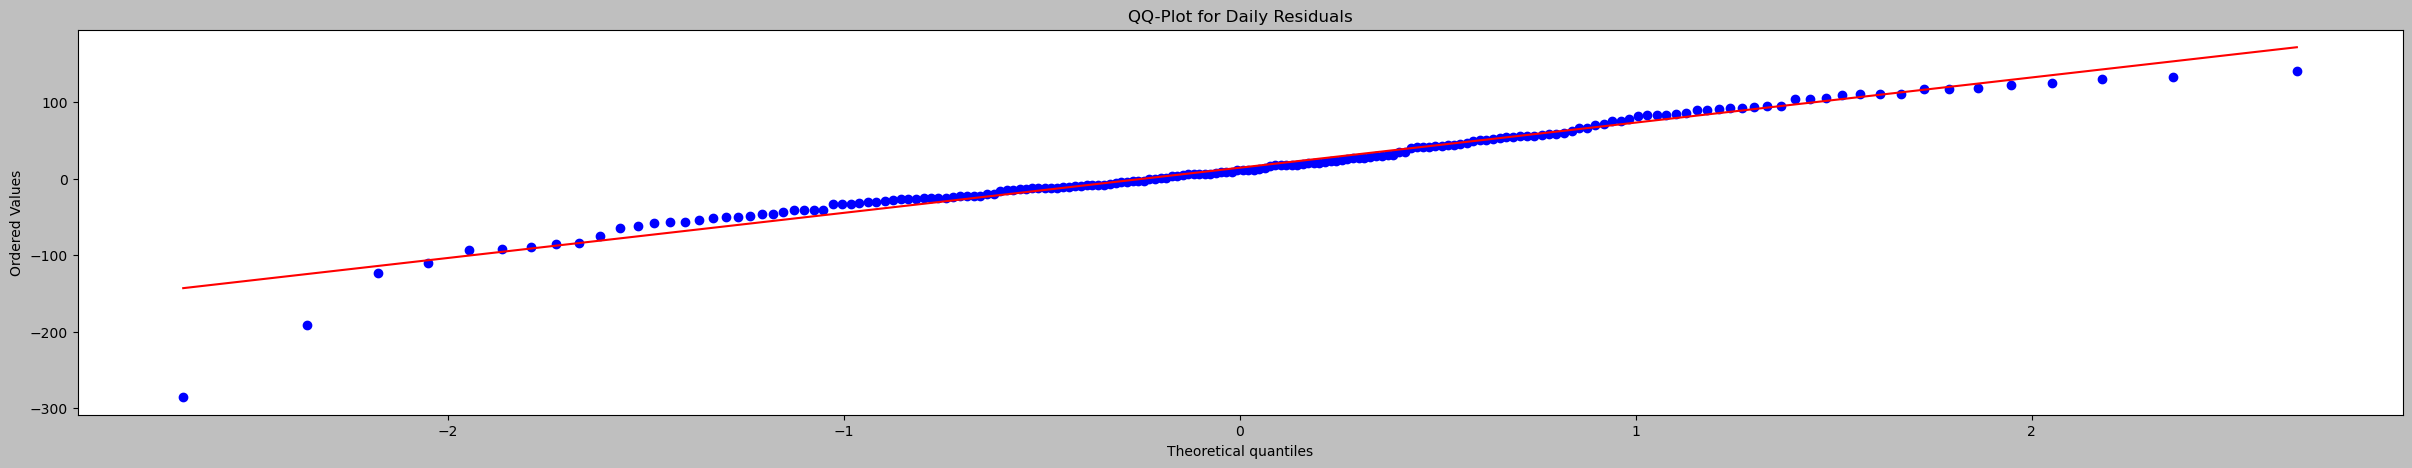

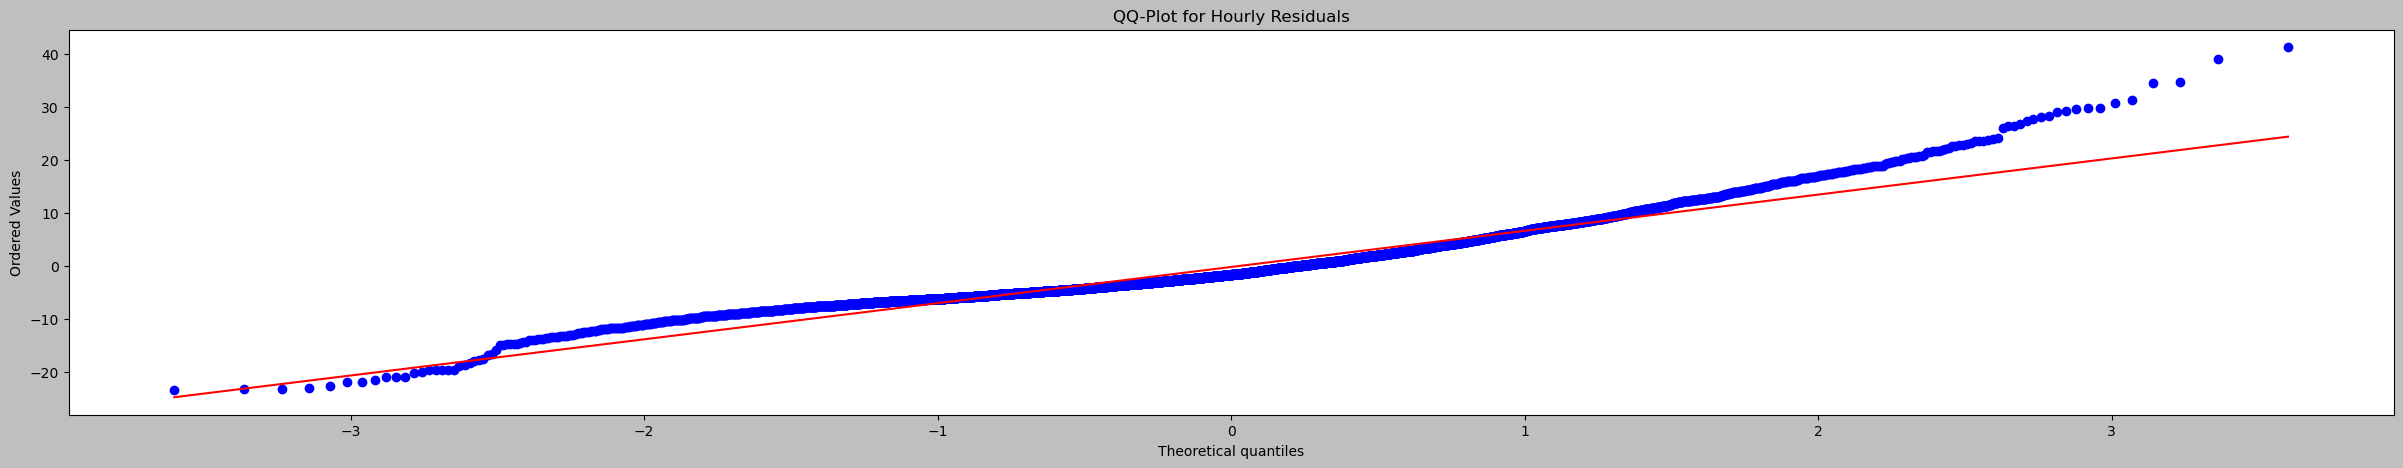

In [56]:
import scipy.stats as stats

# QQ-Plot für Residuen
stats.probplot(residuals_daily.dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot for Daily Residuals')
plt.show()

stats.probplot(residuals_hourly.dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot for Hourly Residuals')
plt.show()

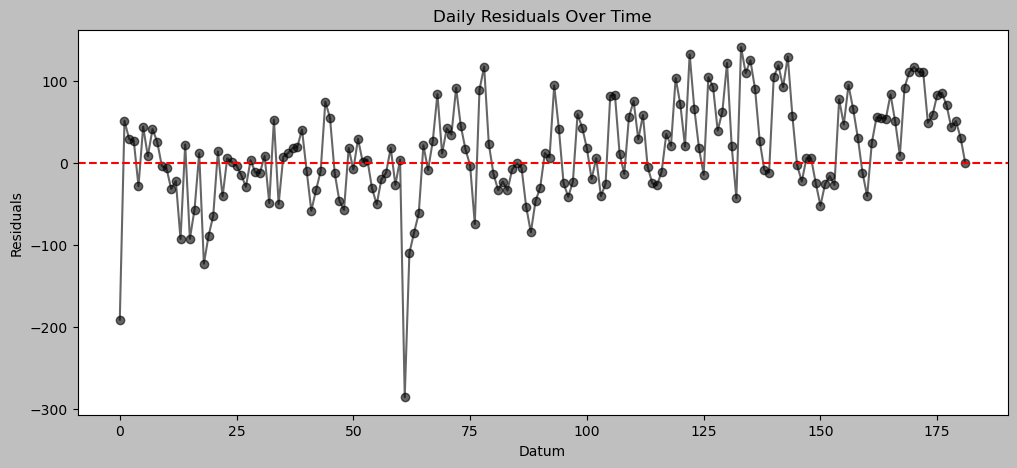

In [60]:
plt.figure(figsize=(12,5))
plt.plot(y_true_daily.index, residuals_daily, marker='o', linestyle='-', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.title('Daily Residuals Over Time')
plt.show()

In [62]:
# Neues Prophet-Modell mit flexiblerem Trend
model = Prophet(
    changepoint_prior_scale=0.1,  # Erhöhe die Trend-Flexibilität
    n_changepoints=50,  # Falls sich der Trend oft ändert
    yearly_seasonality=True,  # Falls du langfristige Schwankungen erwartest
    weekly_seasonality=True  # Falls Wochentage eine Rolle spielen
)

# Falls monatliche Muster eine Rolle spielen:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [63]:
model.fit(df_daily)

09:55:29 - cmdstanpy - INFO - Chain [1] start processing
09:55:34 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = model.make_future_dataframe(periods=30)  # Vorhersage für 30 Tage in die Zukunft
forecast = model.predict(future)

In [65]:
future = model.make_future_dataframe(periods=720, freq="H")  # 720 Stunden (~30 Tage)


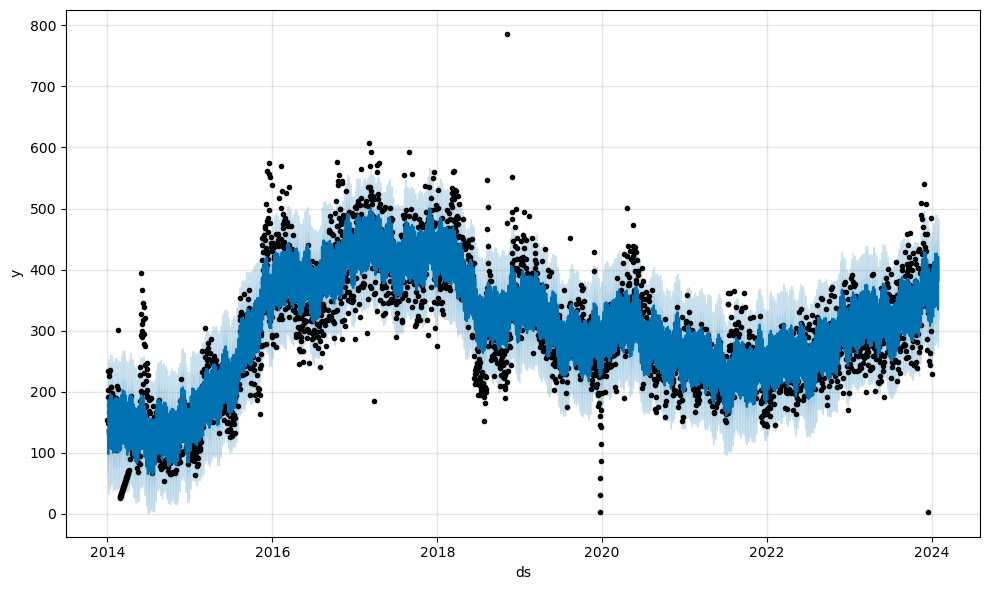

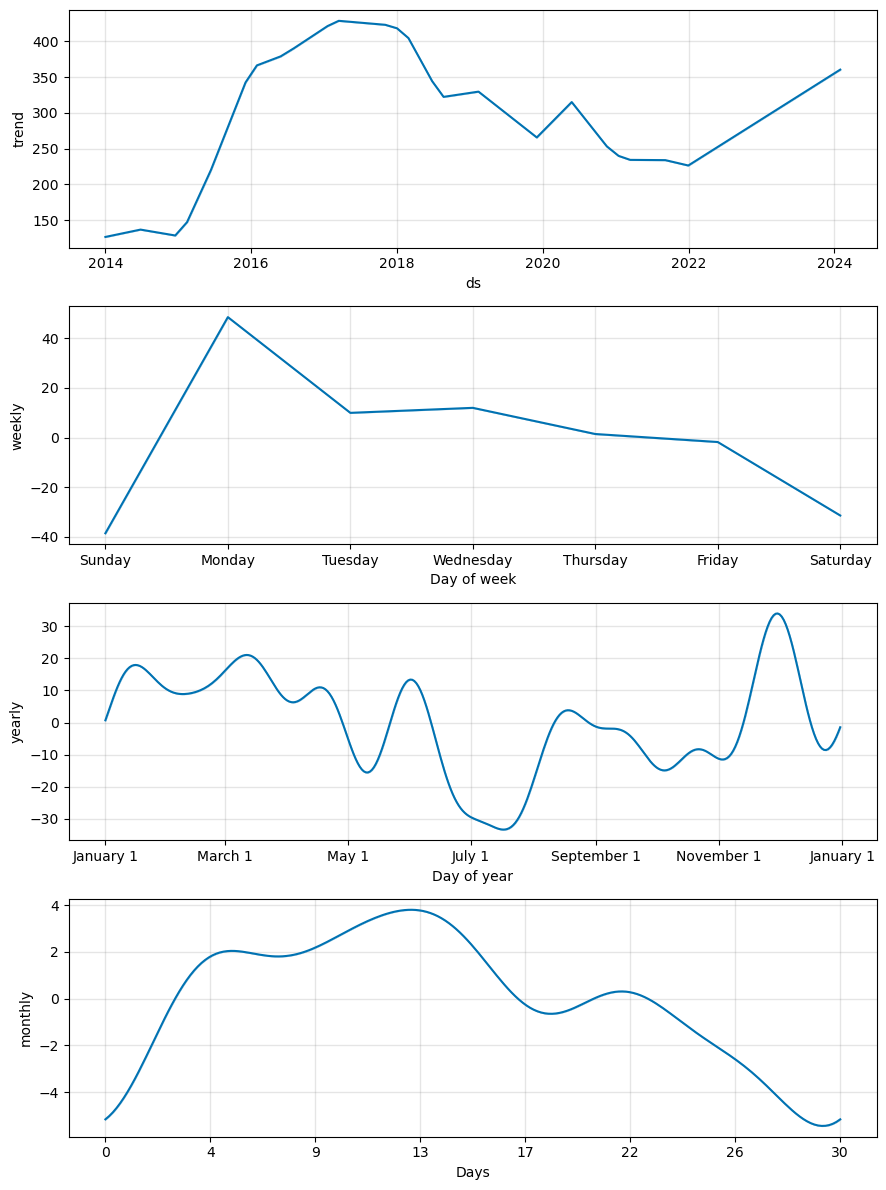

In [66]:
model.plot(forecast)
plt.show()

model.plot_components(forecast)
plt.show()

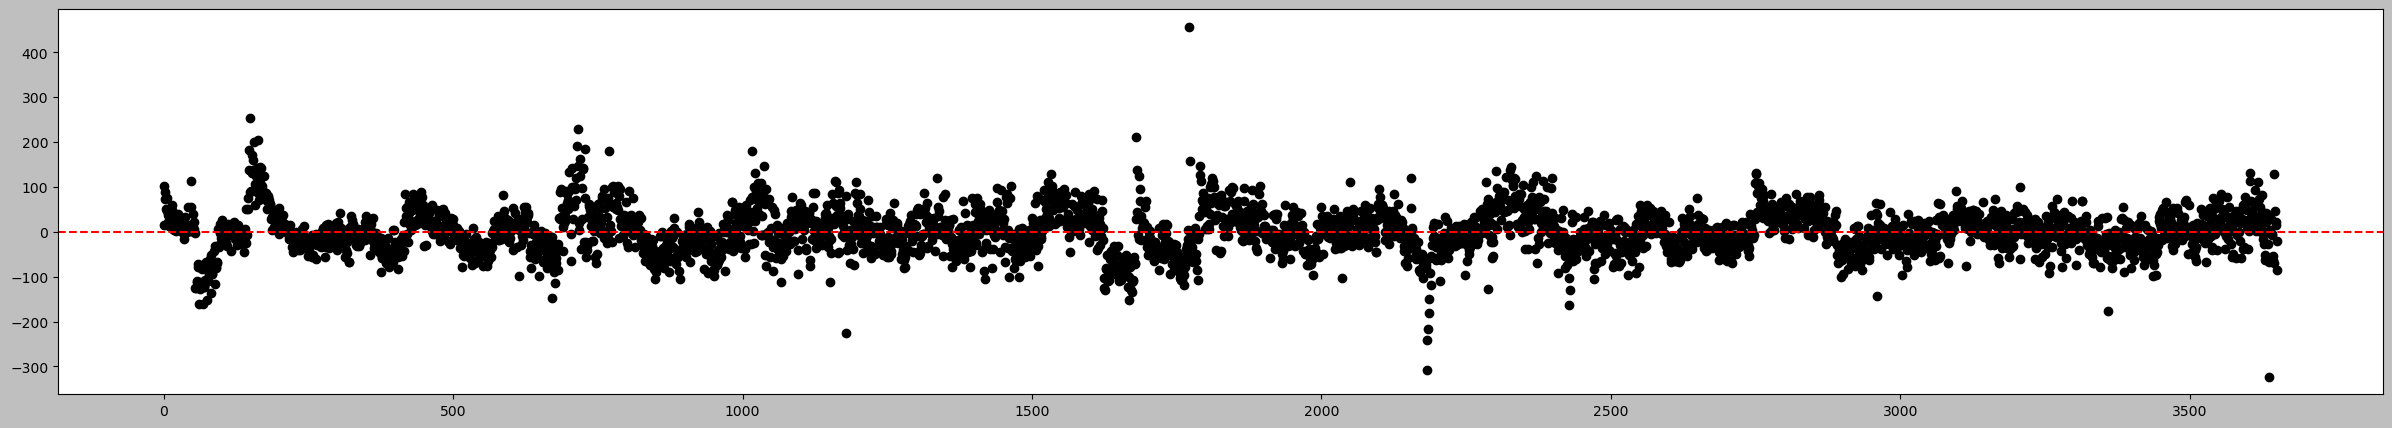

In [67]:
residuals = df_daily["y"] - forecast["yhat"][:len(df_daily)]
plt.scatter(df_daily.index, residuals, color='black')
plt.axhline(0, color='red', linestyle='dashed')
plt.show()

In [68]:

# Vorhersage für df_daily_test
forecast_test = model.predict(df_daily_test)

# Nur relevante Spalten anzeigen
forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]]

ds        yhat  yhat_lower  yhat_upper
0   2024-01-01  401.772191  339.401600  467.198398
1   2024-01-02  364.441548  299.690832  429.608906
2   2024-01-03  367.704779  307.067350  429.350984
3   2024-01-04  358.240385  293.401225  422.519220
4   2024-01-05  355.988903  295.666860  418.168285
..         ...         ...         ...         ...
177 2024-06-26  370.910822  305.927387  438.909506
178 2024-06-27  360.086582  295.019929  432.524436
179 2024-06-28  356.908861  290.619032  429.933103
180 2024-06-29  327.192432  258.871542  394.575862
181 2024-06-30  319.477957  252.617706  387.866138

[182 rows x 4 columns]

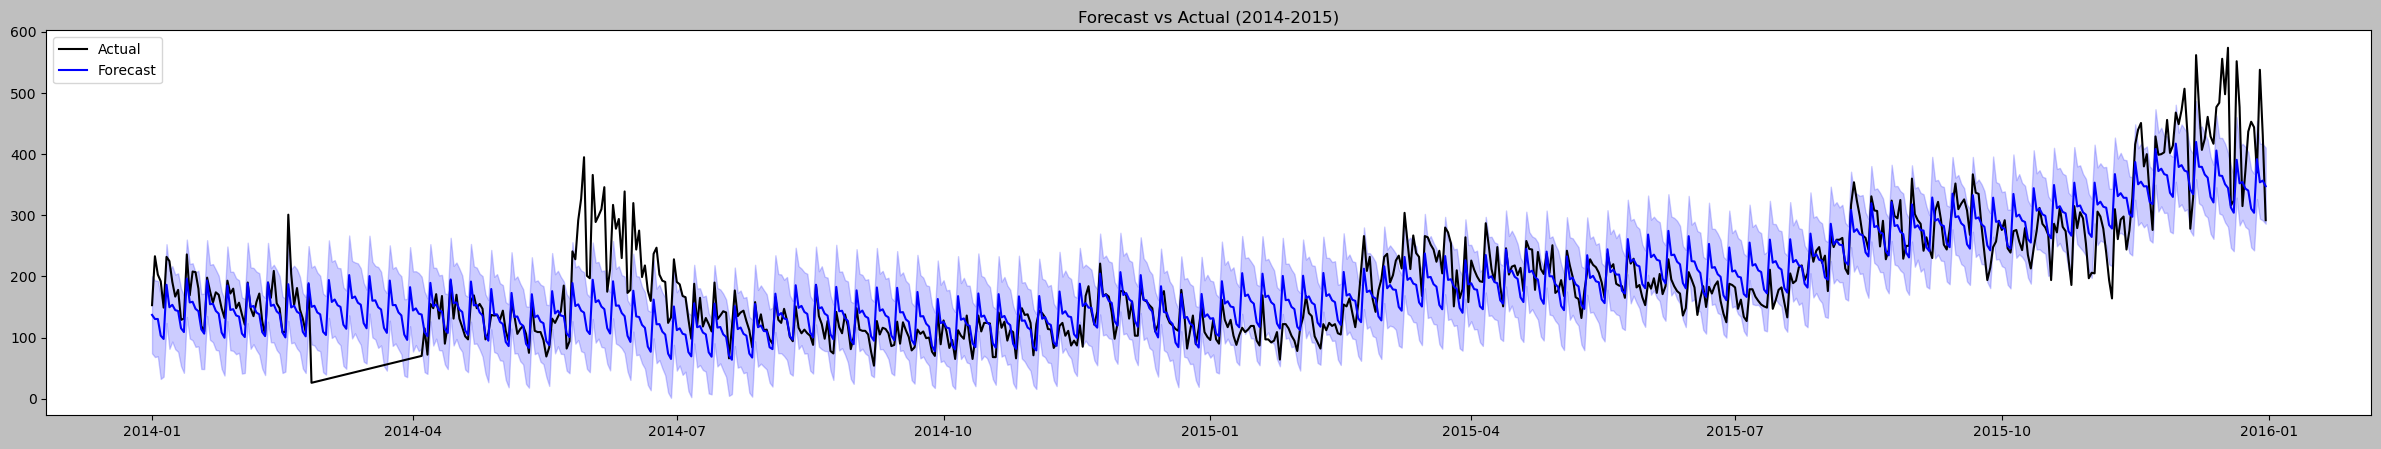

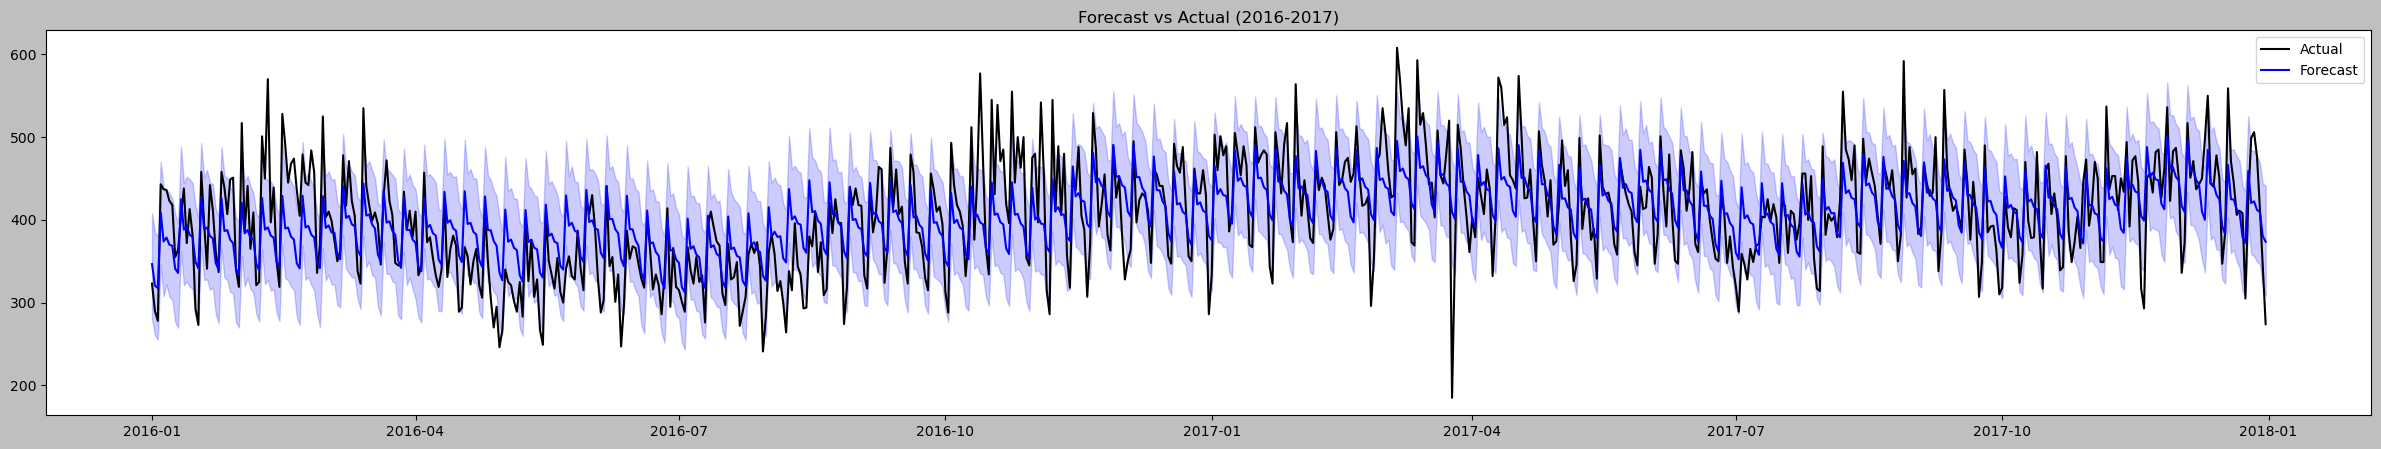

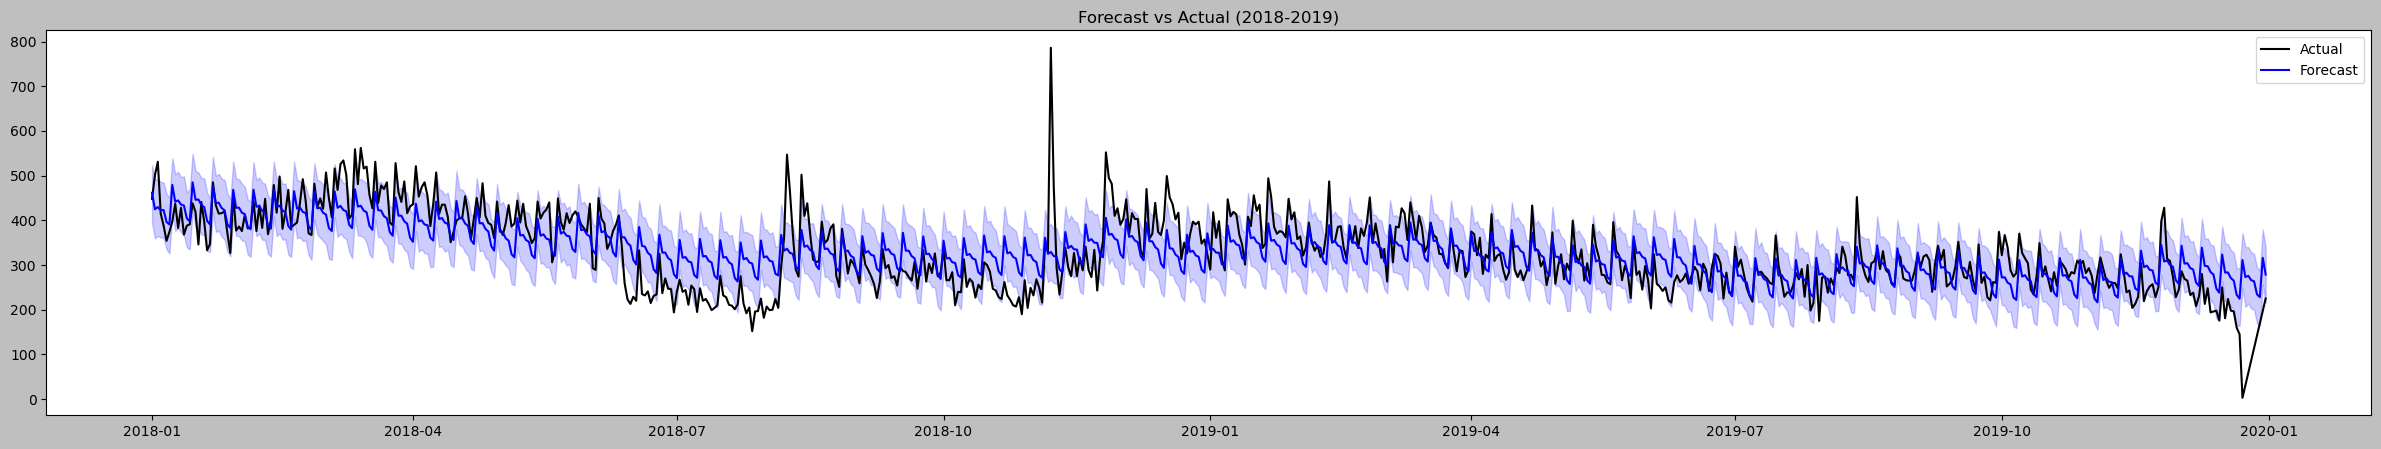

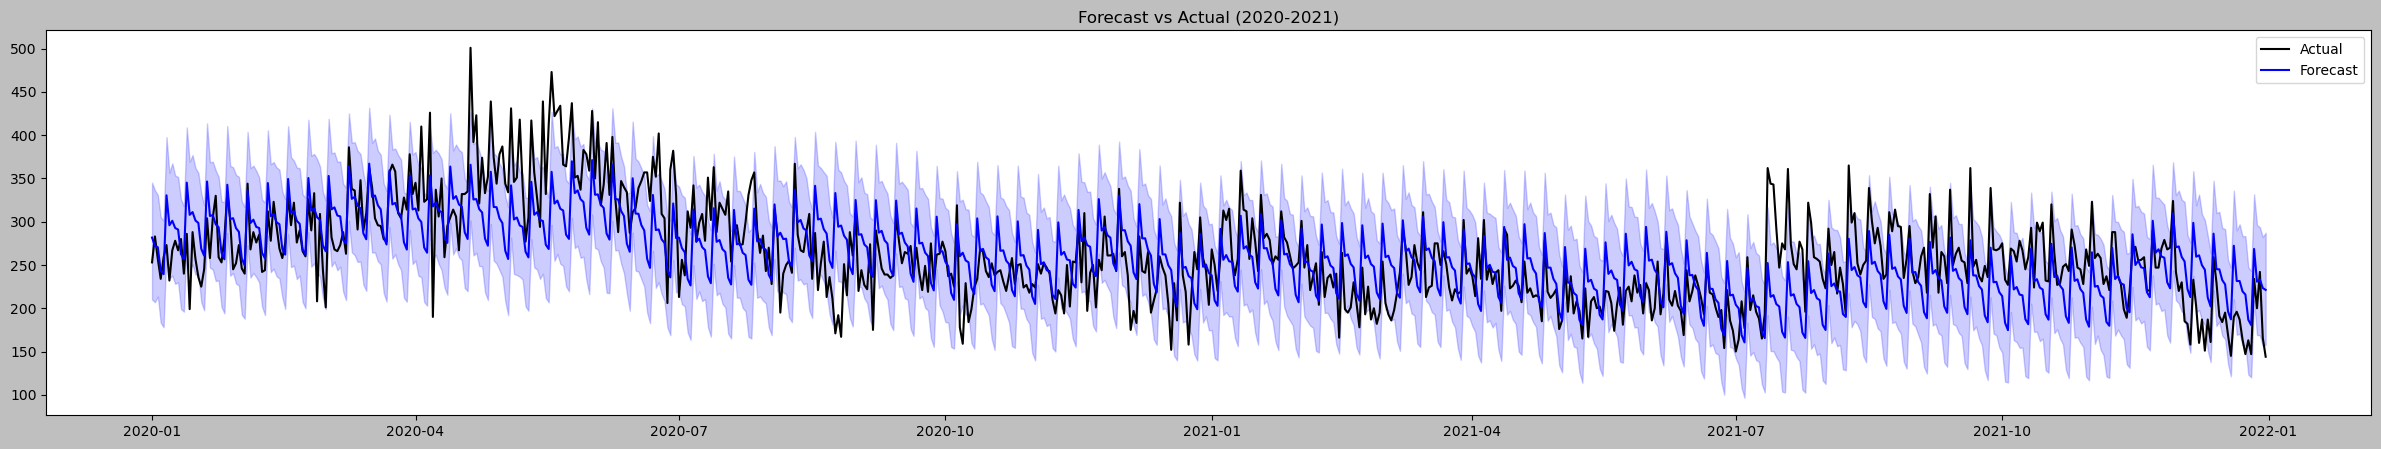

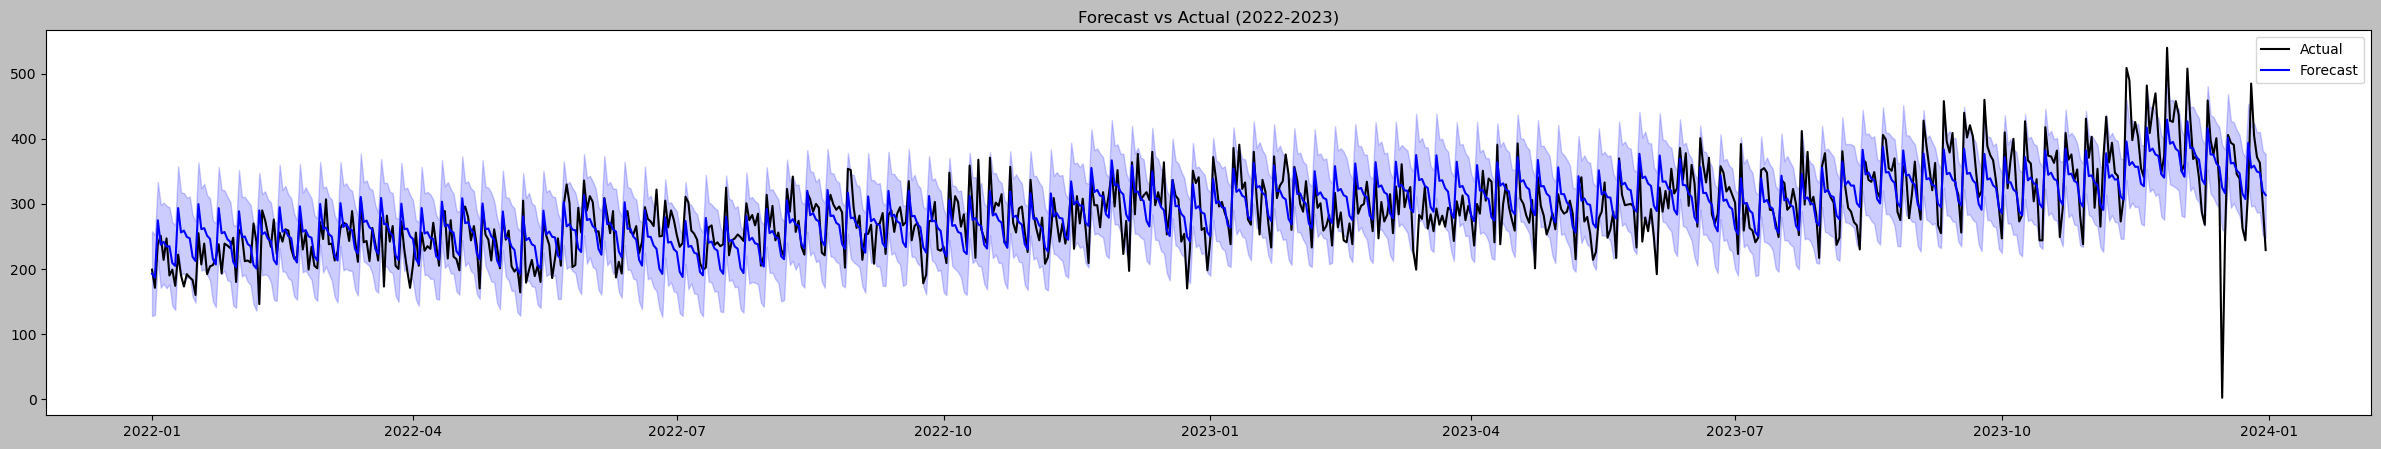

In [75]:
# Konvertiere ds in datetime (falls noch nicht geschehen)
df_daily["ds"] = pd.to_datetime(df_daily["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

# Bestimme den Start- und Endzeitpunkt
start_year = df_daily["ds"].min().year
end_year = df_daily["ds"].max().year

# Erstelle die Plots in 2-Jahres-Intervallen
for year in range(start_year, end_year, 2):
    plt.figure(figsize=(30, 5))
    
    # Definiere den Zeitraum für den aktuellen Plot
    mask_daily = (df_daily["ds"] >= f"{year}-01-01") & (df_daily["ds"] < f"{year+2}-01-01")
    mask_forecast = (forecast["ds"] >= f"{year}-01-01") & (forecast["ds"] < f"{year+2}-01-01")
    
    # Tatsächliche Werte
    plt.plot(df_daily.loc[mask_daily, "ds"], df_daily.loc[mask_daily, "y"], label="Actual", color="black")
    
    # Prophet-Vorhersage
    plt.plot(forecast.loc[mask_forecast, "ds"], forecast.loc[mask_forecast, "yhat"], label="Forecast", color="blue")
    
    # Unsicherheitsbereich
    plt.fill_between(forecast.loc[mask_forecast, "ds"], 
                     forecast.loc[mask_forecast, "yhat_lower"], 
                     forecast.loc[mask_forecast, "yhat_upper"], 
                     color="blue", alpha=0.2)
    
    # Titel & Labels
    plt.title(f"Forecast vs Actual ({year}-{year+1})")
    plt.legend()
    plt.show()


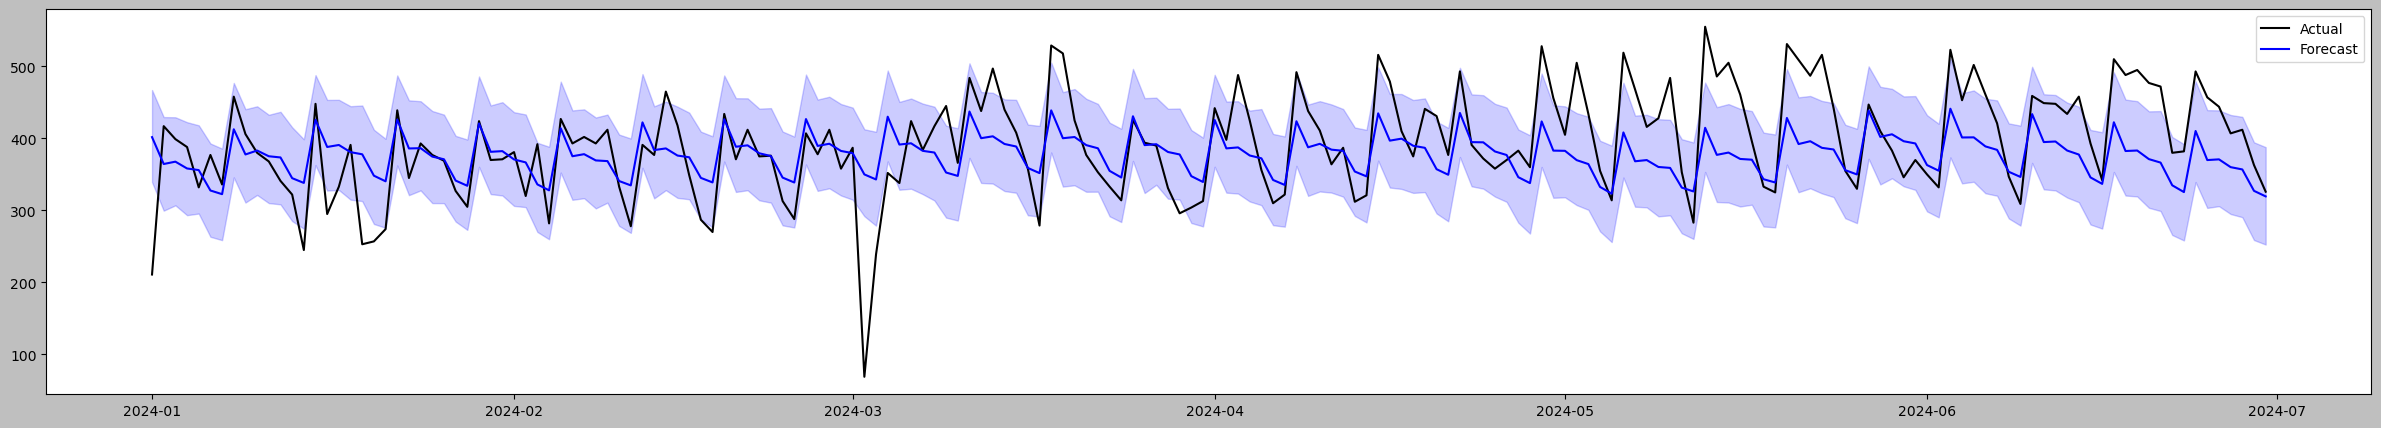

In [70]:
plt.figure(figsize=(30, 5))

# Tatsächliche Werte aus df_daily_test
plt.plot(df_daily_test["ds"], df_daily_test["y"], label="Actual", color="black")

# Prophet-Vorhersage
plt.plot(forecast_test["ds"], forecast_test["yhat"], label="Forecast", color="blue")

# Unsicherheitsbereich
plt.fill_between(forecast_test["ds"], forecast_test["yhat_lower"], forecast_test["yhat_upper"], color="blue", alpha=0.2)

plt.legend()
plt.show()

In [77]:
# Metriken berechnen
mae = mean_absolute_error(df_daily_test["y"], forecast_test["yhat"])
rmse = mean_squared_error(df_daily_test["y"], forecast_test["yhat"], squared=False)

# MAPE (Achtung: Kann problematisch sein, falls Werte nahe 0 sind)
mape = (abs(df_daily_test["y"] - forecast["yhat"]) / df_daily_test["y"]).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 46.58
RMSE: 61.65
MAPE: 64.35%
